In [ ]:
# Import necessary libraries for building and training a GAN

import torch  # Main PyTorch library for creating and training neural networks
from torch.utils.data import DataLoader  # DataLoader helps to manage batches of data
from torch import nn  # Module containing neural network layers and loss functions
from torchvision import transforms  # Library for common image transformations
from torchvision.datasets import MNIST  # Predefined dataset class for the MNIST dataset
from torchvision.utils import make_grid  # Utility for making a grid of images
from tqdm.auto import tqdm  # Library for showing progress bars during training
import matplotlib.pyplot as plt  # Library for plotting and visualizing data

import pdb  # Python Debugger, useful for debugging your code



In [ ]:
# Visualization function to display images from a tensor
def show(tensor, ch=1, size=(28,28), num=16):
    """
    Visualize a batch of images.

    Parameters:
    tensor (torch.Tensor): The tensor containing image data, expected to be 2D (num_samples x flattened_image_size).
    ch (int): Number of channels in the image (default is 1 for grayscale images).
    size (tuple): The size of the image (default is (28, 28) for MNIST).
    num (int): Number of images to display (default is 16).

    Returns:
    None
    """
    # Detach the tensor from the computational graph, move it to CPU, and reshape it to the appropriate dimensions
    data = tensor.detach().cpu().view(-1, ch, *size)  # Reshape to (num_samples, channels, height, width)

    # Create a grid of images, specifying the number of images per row
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0)  # Rearrange dimensions for plotting (height, width, channels)

    # Plot the grid of images
    plt.imshow(grid)
    plt.axis('off')  # Hide the axis for a cleaner look
    plt.show()  # Display the plot


In [ ]:
# Setup of the main parameters and hyperparameters for the GAN training

# Number of epochs to train the GAN
epochs = 100

# Variables to keep track of current training step and logging information
cur_step = 0
info_step = 300  # Frequency of logging information

# Variables to store the running average of generator and discriminator losses
mean_gen_loss = 0
mean_disc_loss = 0

# Dimension of the noise vector (latent space)
z_dim = 64

# Learning rate for the optimizer
lr = 0.00001

# Loss function for the GAN (Binary Cross Entropy with Logits)
loss_func = nn.BCEWithLogitsLoss()

# Batch size for training
bs = 128

# Device configuration: use GPU if available
device = 'cuda'

# Create a DataLoader for the MNIST dataset
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),  # Load MNIST dataset and transform to tensor
    shuffle=True,  # Shuffle the data at every epoch
    batch_size=bs  # Number of samples per batch
)

# Comment indicating the calculation of the number of steps per epoch
# Number of steps per epoch = Total number of samples in MNIST / Batch size = 60000 / 128 ≈ 468.75


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2921642.66it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490765.68it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4465824.15it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4411887.16it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# Declare our models for the GAN: Generator and Discriminator

# Function to create a block of layers for the generator
def genBlock(inp, out):
    """
    Create a block for the generator consisting of a Linear layer,
    Batch Normalization, and ReLU activation function.

    Parameters:
    inp (int): Number of input features
    out (int): Number of output features

    Returns:
    nn.Sequential: A sequential container of the layers
    """
    return nn.Sequential(
        nn.Linear(inp, out),  # Fully connected layer
        nn.BatchNorm1d(out),  # Batch normalization for stable training
        nn.ReLU(inplace=True)  # ReLU activation for introducing non-linearity
    )

# Generator class definition
class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        """
        Initialize the Generator model.

        Parameters:
        z_dim (int): Dimension of the noise vector (latent space)
        i_dim (int): Dimension of the output image (28x28 flattened to 784)
        h_dim (int): Dimension of the hidden layers
        """
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim),  # First hidden layer
            genBlock(h_dim, h_dim * 2),  # Second hidden layer
            genBlock(h_dim * 2, h_dim * 4),  # Third hidden layer
            genBlock(h_dim * 4, h_dim * 8),  # Fourth hidden layer
            nn.Linear(h_dim * 8, i_dim),  # Output layer to match the image size
            nn.Sigmoid(),  # Sigmoid activation to get pixel values between 0 and 1
        )

    def forward(self, noise):
        """
        Forward pass for the generator.

        Parameters:
        noise (torch.Tensor): Input noise tensor

        Returns:
        torch.Tensor: Generated image tensor
        """
        return self.gen(noise)

# Function to generate noise vectors for the generator input
def gen_noise(number, z_dim):
    """
    Generate random noise vectors.

    Parameters:
    number (int): Number of noise vectors to generate
    z_dim (int): Dimension of each noise vector

    Returns:
    torch.Tensor: A tensor of random noise vectors
    """
    return torch.randn(number, z_dim).to(device)

# Function to create a block of layers for the discriminator
def discBlock(inp, out):
    """
    Create a block for the discriminator consisting of a Linear layer
    and LeakyReLU activation function.

    Parameters:
    inp (int): Number of input features
    out (int): Number of output features

    Returns:
    nn.Sequential: A sequential container of the layers
    """
    return nn.Sequential(
        nn.Linear(inp, out),  # Fully connected layer
        nn.LeakyReLU(0.2)  # LeakyReLU activation with a small negative slope
    )

# Discriminator class definition
class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim=256):
        """
        Initialize the Discriminator model.

        Parameters:
        i_dim (int): Dimension of the input image (28x28 flattened to 784)
        h_dim (int): Dimension of the hidden layers
        """
        super().__init__()
        self.disc = nn.Sequential(
            discBlock(i_dim, h_dim * 4),  # First hidden layer
            discBlock(h_dim * 4, h_dim * 2),  # Second hidden layer
            discBlock(h_dim * 2, h_dim),  # Third hidden layer
            nn.Linear(h_dim, 1)  # Output layer to produce a single value (real/fake)
        )

    def forward(self, image):
        """
        Forward pass for the discriminator.

        Parameters:
        image (torch.Tensor): Input image tensor

        Returns:
        torch.Tensor: Single value indicating real or fake
        """
        return self.disc(image)


In [ ]:
# Instantiate the Generator and move it to the specified device (GPU if available)
gen = Generator(z_dim).to(device)
# The generator is responsible for generating fake images from random noise.
# Moving it to the GPU accelerates the training process.

# Define the optimizer for the generator using the Adam optimization algorithm
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
# The Adam optimizer is used here for its adaptive learning rate properties,
# which helps in faster convergence. It updates the generator's parameters
# based on the gradients computed during backpropagation.

# Instantiate the Discriminator and move it to the specified device (GPU if available)
disc = Discriminator().to(device)
# The discriminator is responsible for distinguishing between real and fake images.
# Moving it to the GPU accelerates the training process.

# Define the optimizer for the discriminator using the Adam optimization algorithm
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
# The Adam optimizer is used here for its adaptive learning rate properties,
# which helps in faster convergence. It updates the discriminator's parameters
# based on the gradients computed during backpropagation.


torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([2, 5, 9, 4, 2, 9, 0, 0, 1, 7])


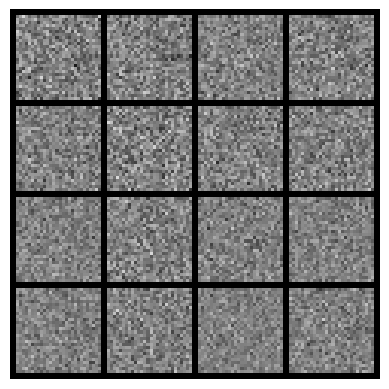

In [ ]:
# Retrieve one batch of data from the dataloader
x, y = next(iter(dataloader))
# The dataloader provides an iterator over the dataset. 'next(iter(dataloader))' gets the next batch of data.
# 'x' contains the images and 'y' contains the labels.

# Print the shape of the images and labels tensors
print(x.shape, y.shape)
# The shape of 'x' will be [batch_size, channels, height, width], typically [128, 1, 28, 28] for MNIST.
# The shape of 'y' will be [batch_size], typically [128] for MNIST, containing the labels.

# Print the first 10 labels of the batch
print(y[:10])
# This displays the first 10 labels from the batch, which helps in understanding the data distribution.

# Generate random noise vectors for the generator input
noise = gen_noise(bs, z_dim)
# 'gen_noise' generates 'bs' (batch size) noise vectors, each of dimension 'z_dim'.
# These noise vectors are the input for the generator to create fake images.

# Use the generator to create fake images from the noise vectors
fake = gen(noise)
# The generator transforms the noise vectors into fake images.
# 'fake' will have the shape [batch_size, image_size], typically [128, 784] for MNIST.

# Visualize the generated fake images
show(fake)
# The 'show' function displays a grid of fake images generated by the GAN.
# This helps in visually inspecting the quality of the generated images.


In [ ]:
# Function to calculate the generator's loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    """
    Calculate the loss for the generator.

    Parameters:
    loss_func (nn.Module): Loss function to use (e.g., BCEWithLogitsLoss)
    gen (nn.Module): Generator model
    disc (nn.Module): Discriminator model
    number (int): Number of samples to generate
    z_dim (int): Dimension of the noise vector

    Returns:
    torch.Tensor: Calculated loss for the generator
    """
    # Generate random noise vectors
    noise = gen_noise(number, z_dim)
    # Use the generator to create fake images from the noise
    fake = gen(noise)
    # Get the discriminator's predictions for the fake images
    pred = disc(fake)
    # Create target labels (all ones) indicating these are real images
    targets = torch.ones_like(pred)
    # Calculate the loss between the discriminator's predictions and the real targets
    gen_loss = loss_func(pred, targets)

    return gen_loss

# Function to calculate the discriminator's loss
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
    """
    Calculate the loss for the discriminator.

    Parameters:
    loss_func (nn.Module): Loss function to use (e.g., BCEWithLogitsLoss)
    gen (nn.Module): Generator model
    disc (nn.Module): Discriminator model
    number (int): Number of samples to generate
    real (torch.Tensor): Batch of real images
    z_dim (int): Dimension of the noise vector

    Returns:
    torch.Tensor: Calculated loss for the discriminator
    """
    # Generate random noise vectors
    noise = gen_noise(number, z_dim)
    # Use the generator to create fake images from the noise
    fake = gen(noise)
    # Get the discriminator's predictions for the fake images
    disc_fake = disc(fake.detach())
    # Create target labels (all zeros) indicating these are fake images
    disc_fake_targets = torch.zeros_like(disc_fake)
    # Calculate the loss between the discriminator's predictions and the fake targets
    disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

    # Get the discriminator's predictions for the real images
    disc_real = disc(real)
    # Create target labels (all ones) indicating these are real images
    disc_real_targets = torch.ones_like(disc_real)
    # Calculate the loss between the discriminator's predictions and the real targets
    disc_real_loss = loss_func(disc_real, disc_real_targets)

    # Average the fake and real losses to get the total discriminator loss
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss


  0%|          | 0/469 [00:00<?, ?it/s]

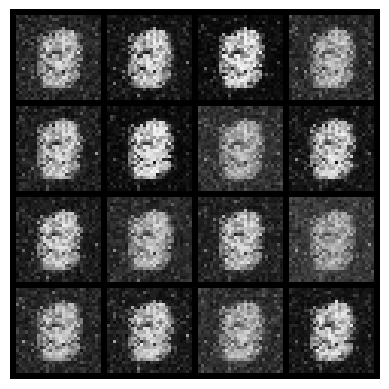

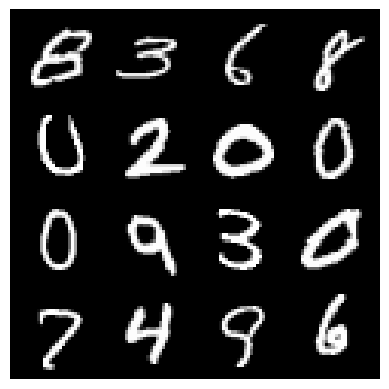

Epoch 0: Step 300 / Gen loss: 2.0757512289285645 / Disc loss: 0.3314047130445636


  0%|          | 0/469 [00:00<?, ?it/s]

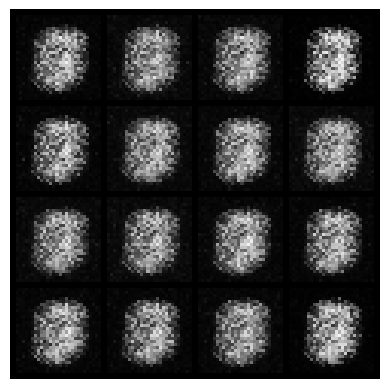

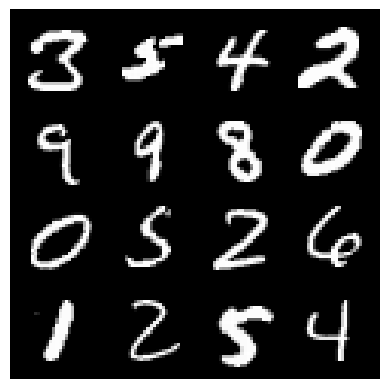

Epoch 1: Step 600 / Gen loss: 3.724789484341942 / Disc loss: 0.11157088629901414


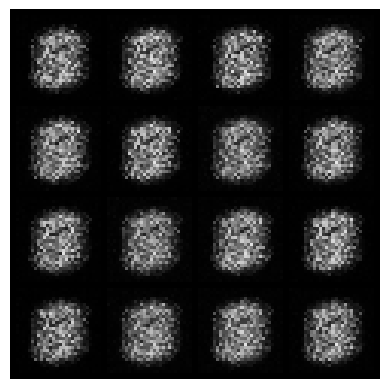

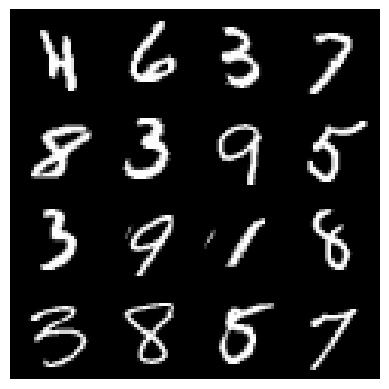

Epoch 1: Step 900 / Gen loss: 3.5941826423009218 / Disc loss: 0.051936350328226855


  0%|          | 0/469 [00:00<?, ?it/s]

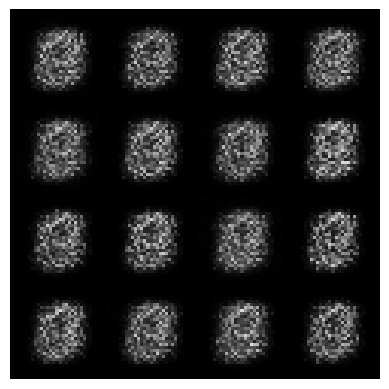

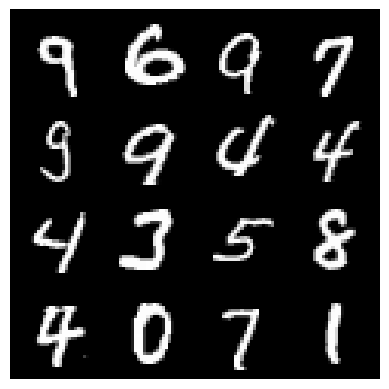

Epoch 2: Step 1200 / Gen loss: 3.604914719263711 / Disc loss: 0.034954846501350396


  0%|          | 0/469 [00:00<?, ?it/s]

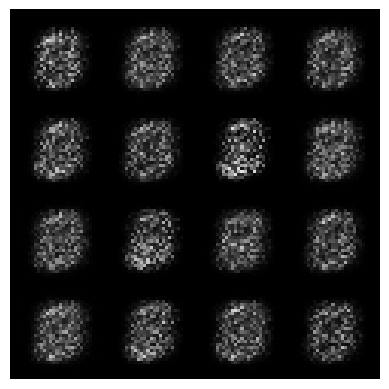

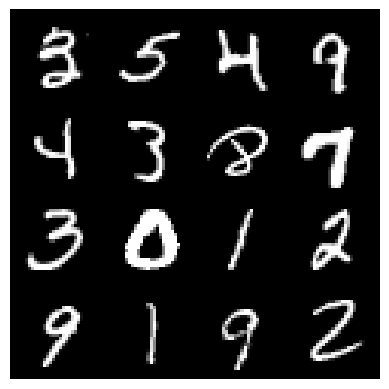

Epoch 3: Step 1500 / Gen loss: 3.4424386898676533 / Disc loss: 0.040645908682296686


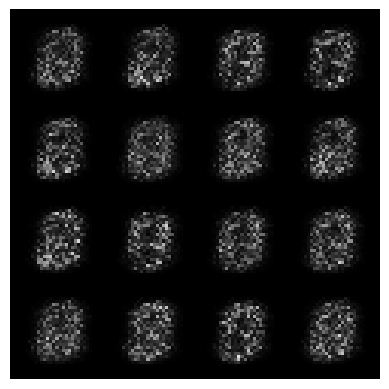

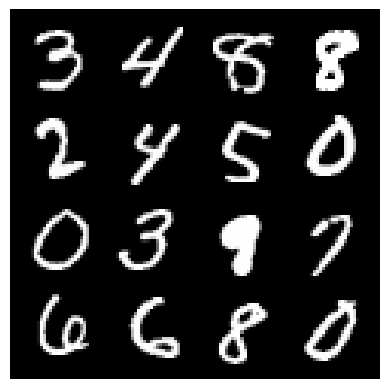

Epoch 3: Step 1800 / Gen loss: 3.4184299802780145 / Disc loss: 0.04731306593244277


  0%|          | 0/469 [00:00<?, ?it/s]

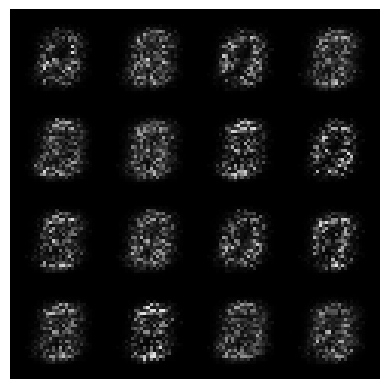

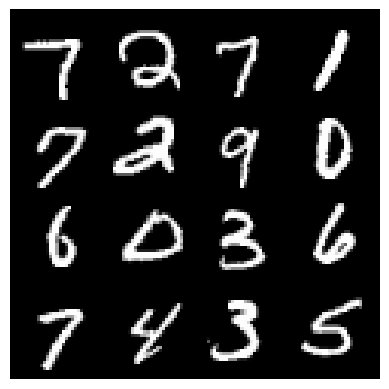

Epoch 4: Step 2100 / Gen loss: 3.585235080718994 / Disc loss: 0.04713151318952438


  0%|          | 0/469 [00:00<?, ?it/s]

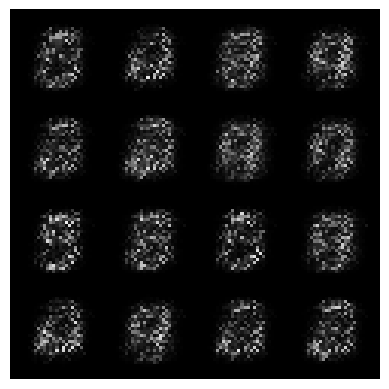

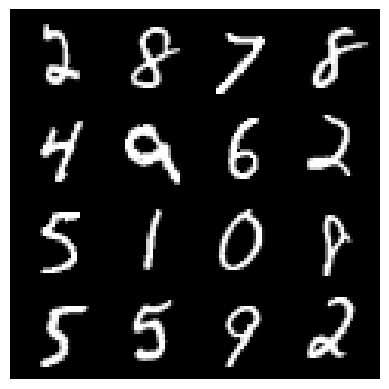

Epoch 5: Step 2400 / Gen loss: 3.7911606343587256 / Disc loss: 0.03996888437618818


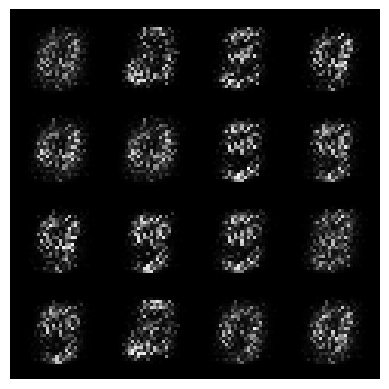

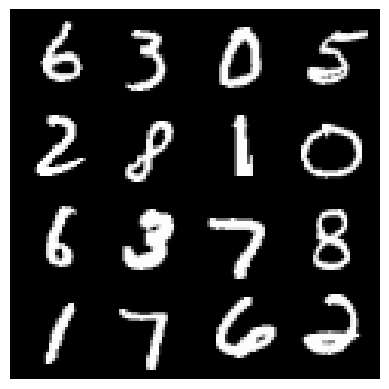

Epoch 5: Step 2700 / Gen loss: 4.525908624331154 / Disc loss: 0.026421676734462385


  0%|          | 0/469 [00:00<?, ?it/s]

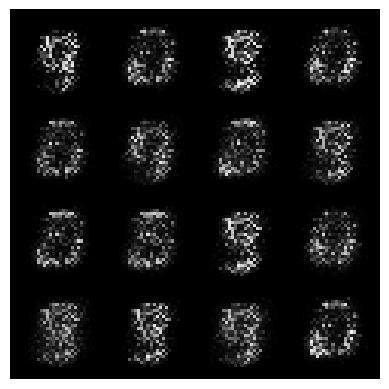

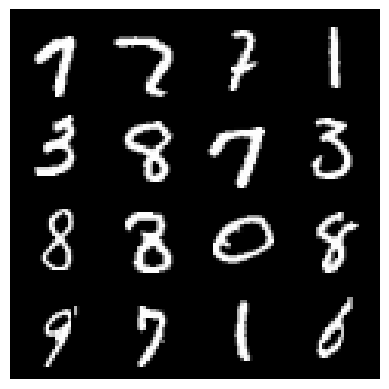

Epoch 6: Step 3000 / Gen loss: 4.654341429074607 / Disc loss: 0.02270827458860974


  0%|          | 0/469 [00:00<?, ?it/s]

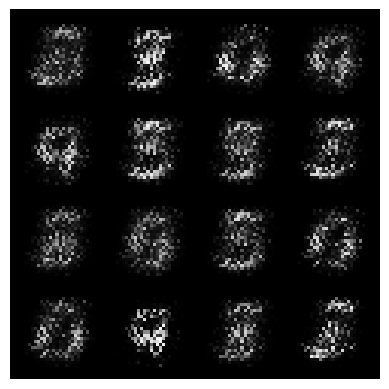

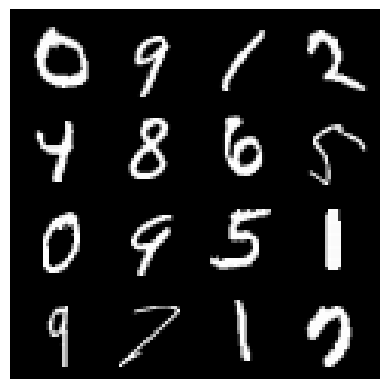

Epoch 7: Step 3300 / Gen loss: 5.214936242103574 / Disc loss: 0.01929817786440253


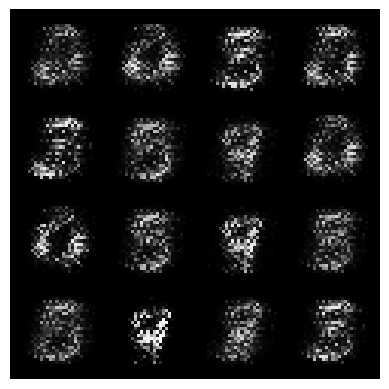

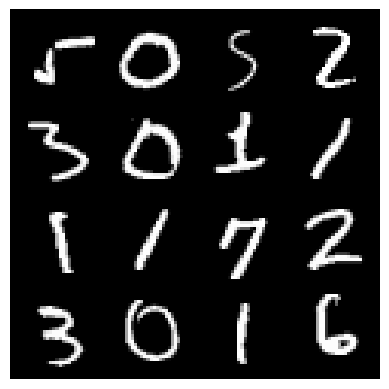

Epoch 7: Step 3600 / Gen loss: 5.459827691713972 / Disc loss: 0.02064630371207991


  0%|          | 0/469 [00:00<?, ?it/s]

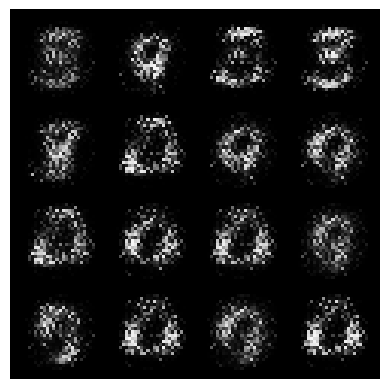

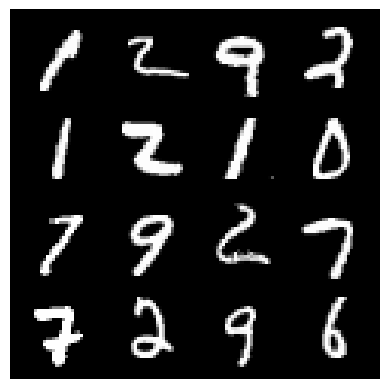

Epoch 8: Step 3900 / Gen loss: 5.561686029434209 / Disc loss: 0.01924909187170365


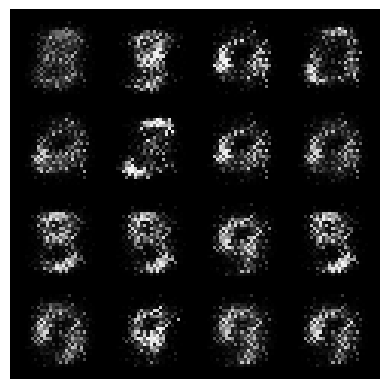

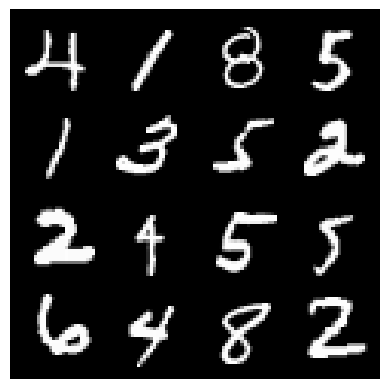

Epoch 8: Step 4200 / Gen loss: 5.857221612930297 / Disc loss: 0.019704140626514963


  0%|          | 0/469 [00:00<?, ?it/s]

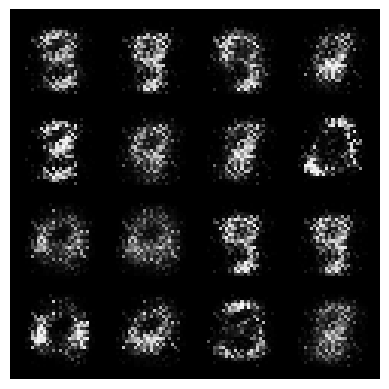

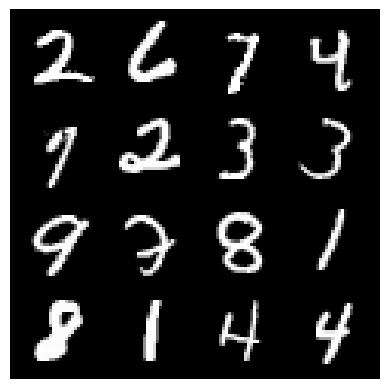

Epoch 9: Step 4500 / Gen loss: 6.374160949389142 / Disc loss: 0.017273297435604032


  0%|          | 0/469 [00:00<?, ?it/s]

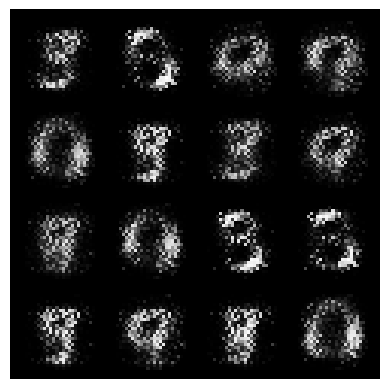

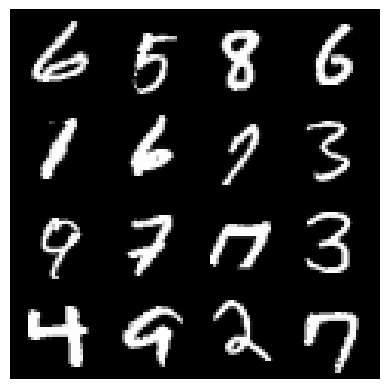

Epoch 10: Step 4800 / Gen loss: 6.339067729314168 / Disc loss: 0.017391061137119926


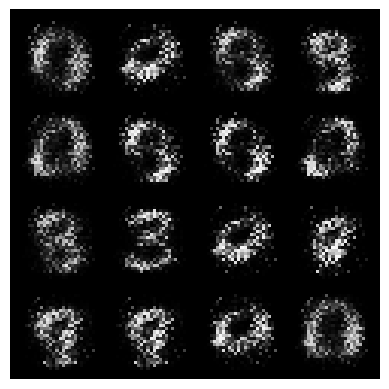

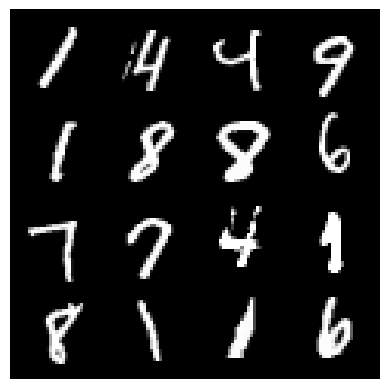

Epoch 10: Step 5100 / Gen loss: 6.255610149701431 / Disc loss: 0.01616124424307297


  0%|          | 0/469 [00:00<?, ?it/s]

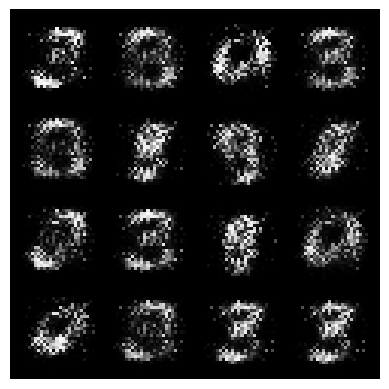

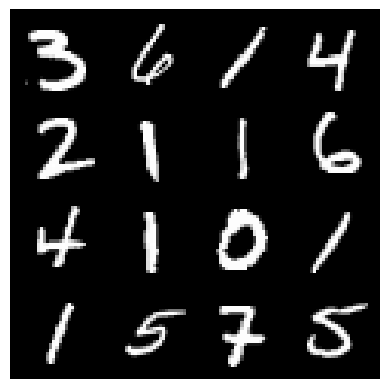

Epoch 11: Step 5400 / Gen loss: 6.354776206016544 / Disc loss: 0.014317965920393663


  0%|          | 0/469 [00:00<?, ?it/s]

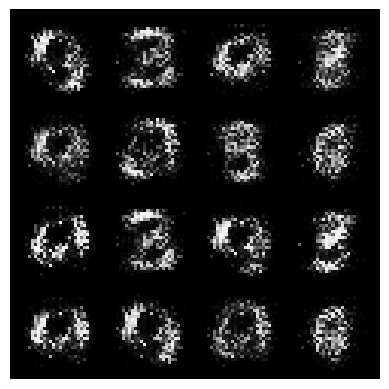

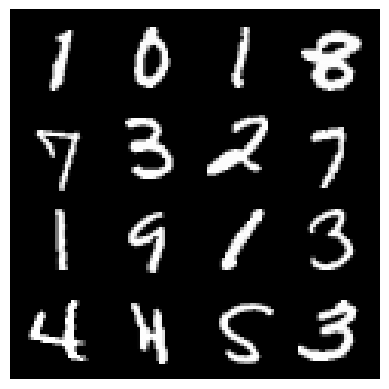

Epoch 12: Step 5700 / Gen loss: 6.7781686131159455 / Disc loss: 0.011547860392990208


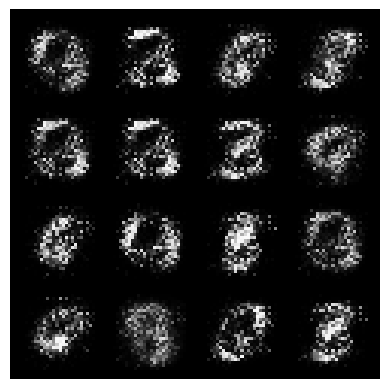

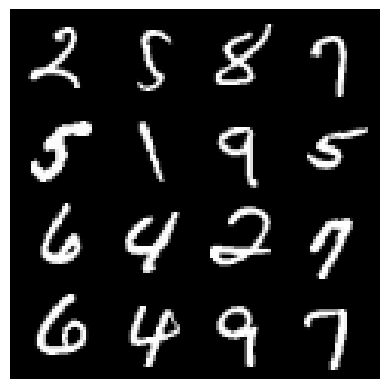

Epoch 12: Step 6000 / Gen loss: 6.801287163098651 / Disc loss: 0.011492592187132696


  0%|          | 0/469 [00:00<?, ?it/s]

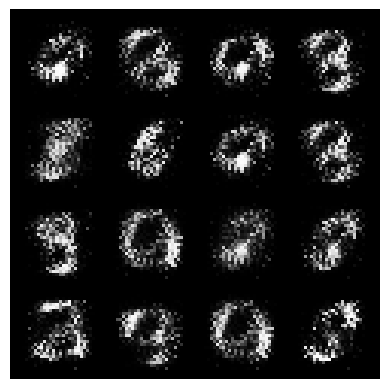

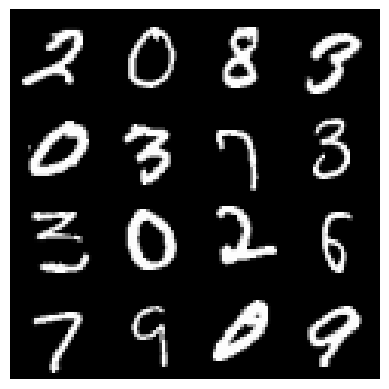

Epoch 13: Step 6300 / Gen loss: 6.967375035285957 / Disc loss: 0.013237625740778948


  0%|          | 0/469 [00:00<?, ?it/s]

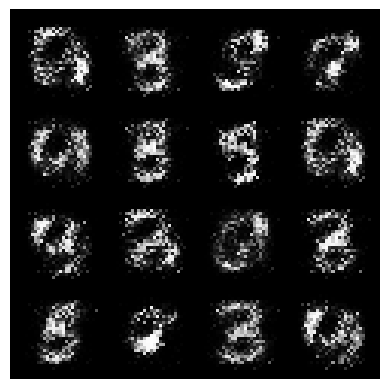

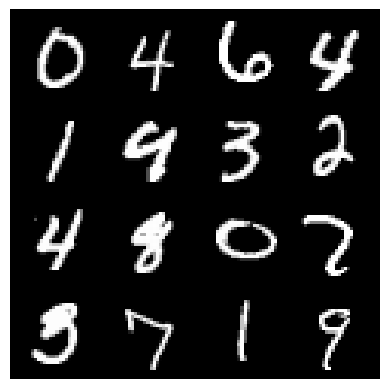

Epoch 14: Step 6600 / Gen loss: 7.025203792254128 / Disc loss: 0.01428406629478559


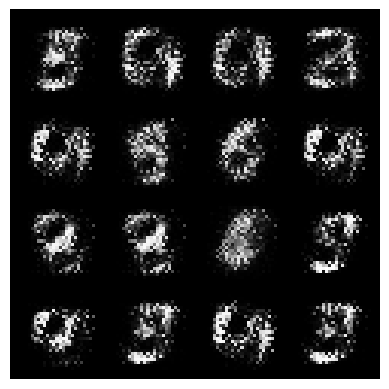

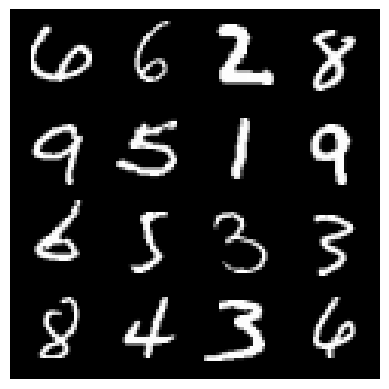

Epoch 14: Step 6900 / Gen loss: 6.751062733332316 / Disc loss: 0.013555672968892998


  0%|          | 0/469 [00:00<?, ?it/s]

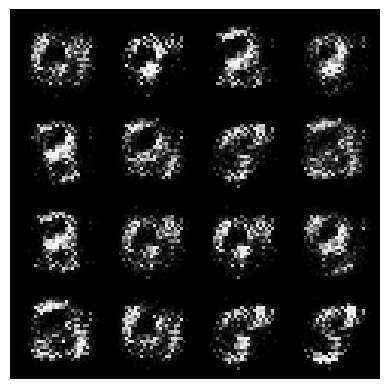

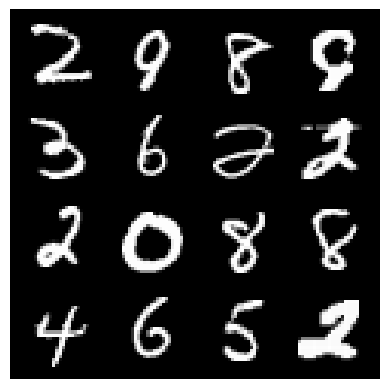

Epoch 15: Step 7200 / Gen loss: 6.958867046038314 / Disc loss: 0.010812177754317717


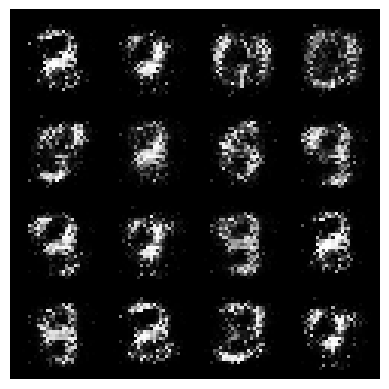

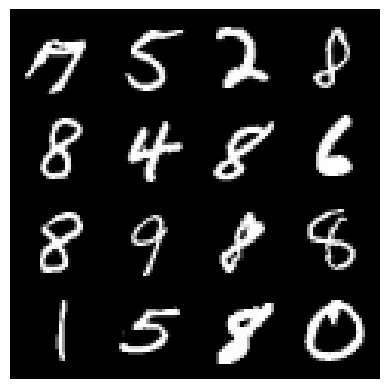

Epoch 15: Step 7500 / Gen loss: 7.200409509340921 / Disc loss: 0.008852254160835099


  0%|          | 0/469 [00:00<?, ?it/s]

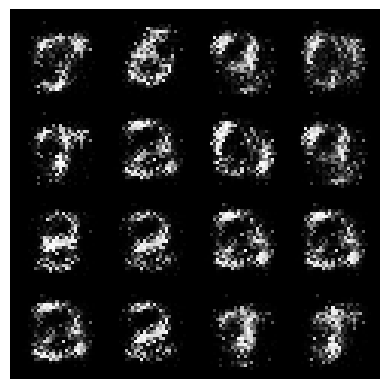

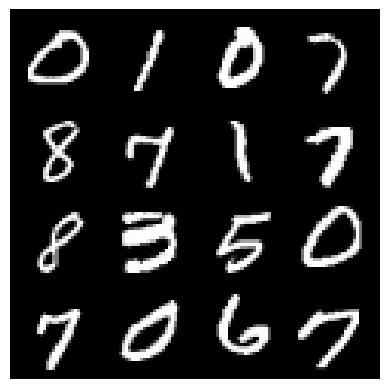

Epoch 16: Step 7800 / Gen loss: 7.4333006763458265 / Disc loss: 0.007830702757152419


  0%|          | 0/469 [00:00<?, ?it/s]

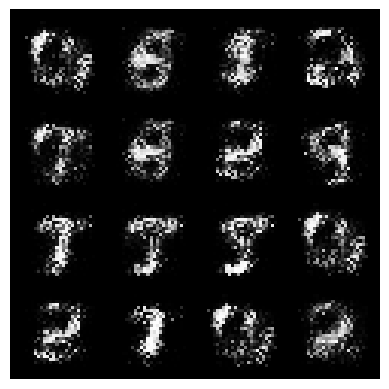

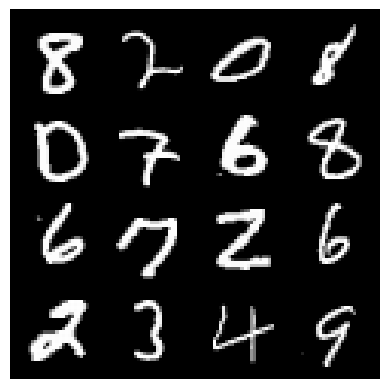

Epoch 17: Step 8100 / Gen loss: 7.5346152544021585 / Disc loss: 0.010081183417156959


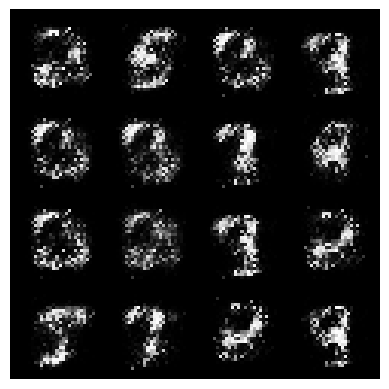

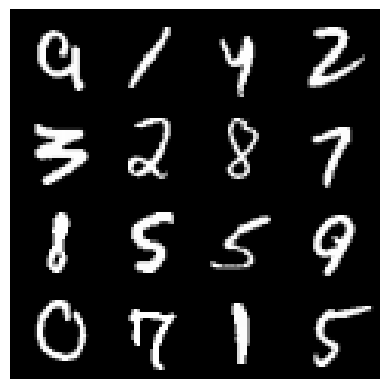

Epoch 17: Step 8400 / Gen loss: 7.502556657791143 / Disc loss: 0.009252179927813506


  0%|          | 0/469 [00:00<?, ?it/s]

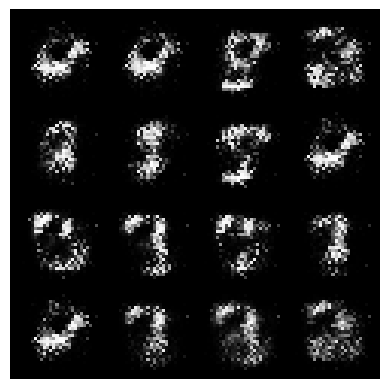

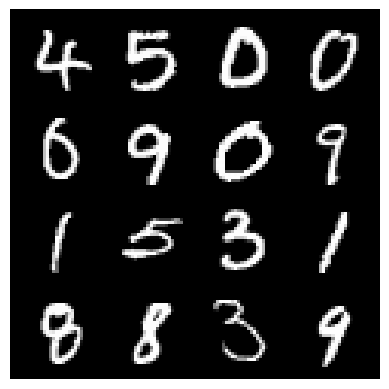

Epoch 18: Step 8700 / Gen loss: 7.107472799619034 / Disc loss: 0.00980448651205128


  0%|          | 0/469 [00:00<?, ?it/s]

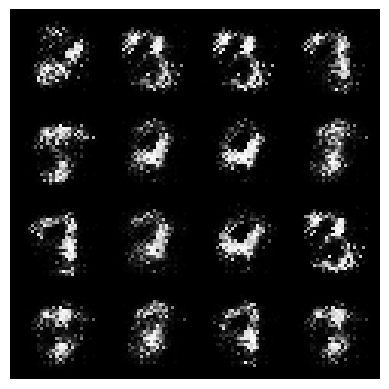

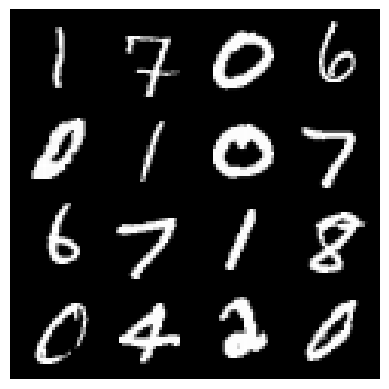

Epoch 19: Step 9000 / Gen loss: 7.032827488581343 / Disc loss: 0.008335097761979961


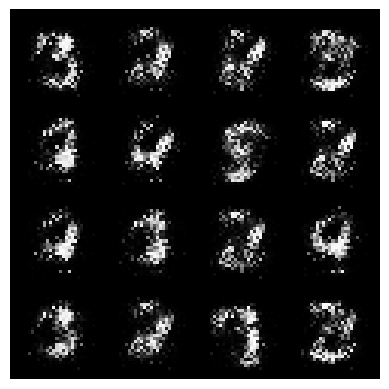

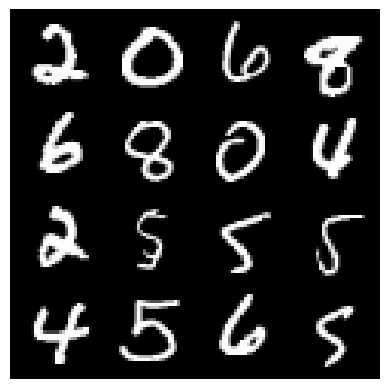

Epoch 19: Step 9300 / Gen loss: 6.874306084314984 / Disc loss: 0.008027061544125899


  0%|          | 0/469 [00:00<?, ?it/s]

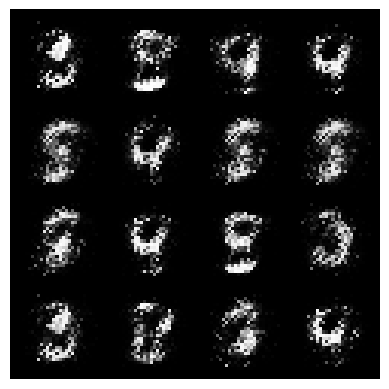

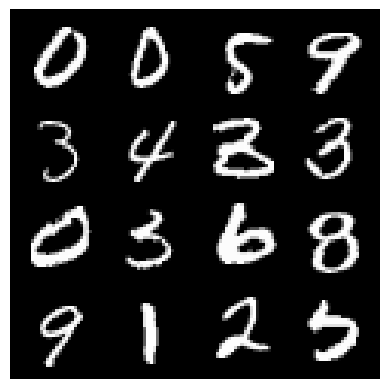

Epoch 20: Step 9600 / Gen loss: 7.244262990951538 / Disc loss: 0.007283540431332462


  0%|          | 0/469 [00:00<?, ?it/s]

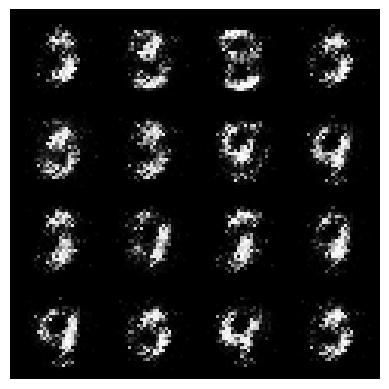

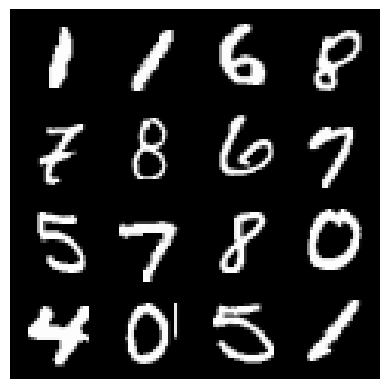

Epoch 21: Step 9900 / Gen loss: 7.28758565425873 / Disc loss: 0.008563478690727306


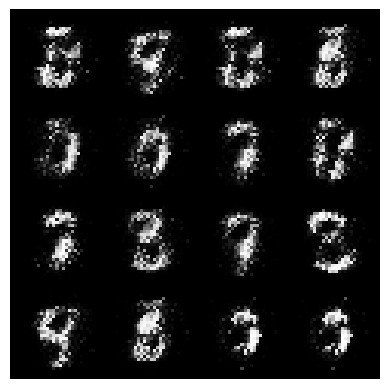

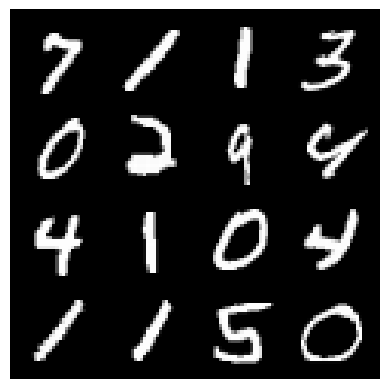

Epoch 21: Step 10200 / Gen loss: 7.199279341697694 / Disc loss: 0.01182303597296898


  0%|          | 0/469 [00:00<?, ?it/s]

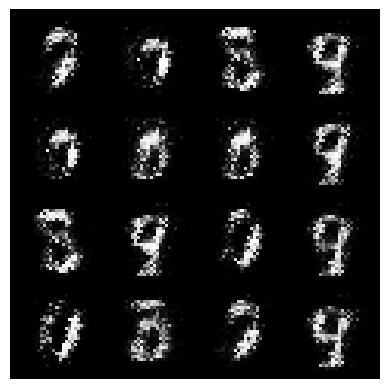

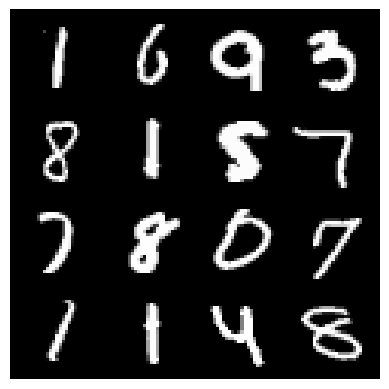

Epoch 22: Step 10500 / Gen loss: 6.7296033859253 / Disc loss: 0.012942982454939442


  0%|          | 0/469 [00:00<?, ?it/s]

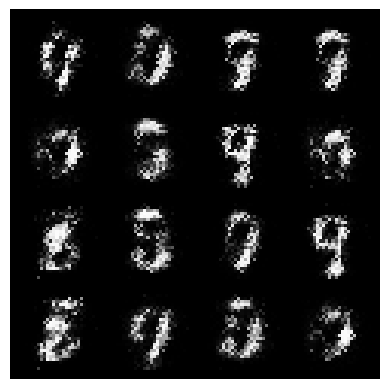

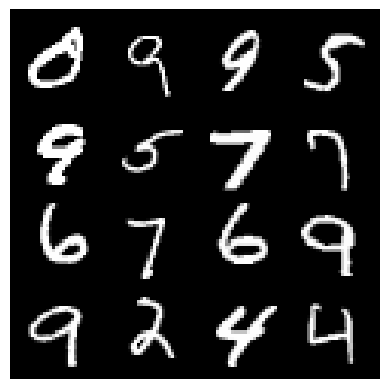

Epoch 23: Step 10800 / Gen loss: 7.002942597071329 / Disc loss: 0.01286173890111968


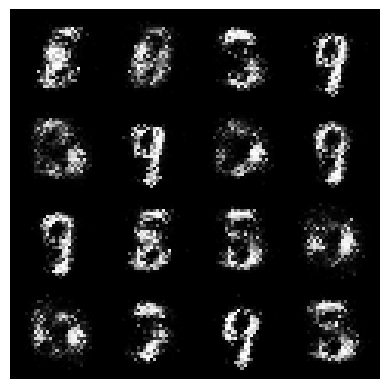

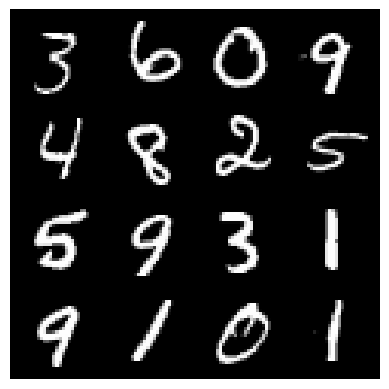

Epoch 23: Step 11100 / Gen loss: 7.099948836962383 / Disc loss: 0.014835082878125823


  0%|          | 0/469 [00:00<?, ?it/s]

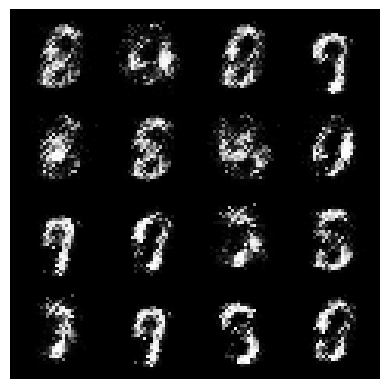

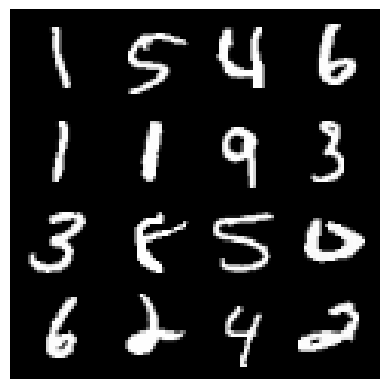

Epoch 24: Step 11400 / Gen loss: 6.288215330441794 / Disc loss: 0.01567072669587408


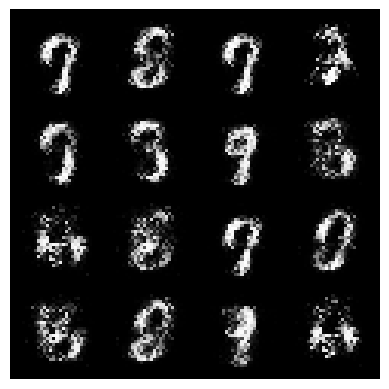

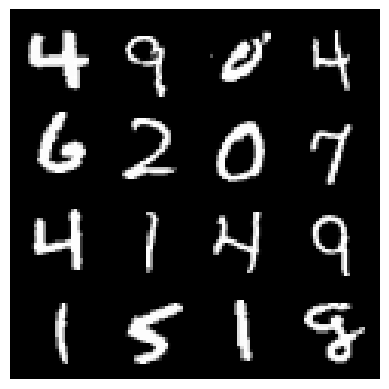

Epoch 24: Step 11700 / Gen loss: 6.303827802340181 / Disc loss: 0.014613074088313933


  0%|          | 0/469 [00:00<?, ?it/s]

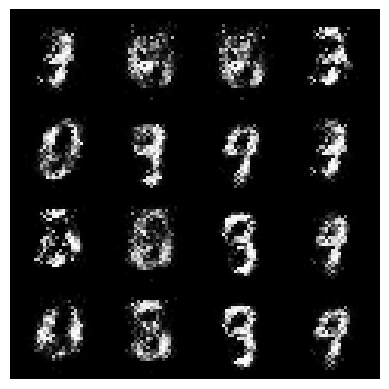

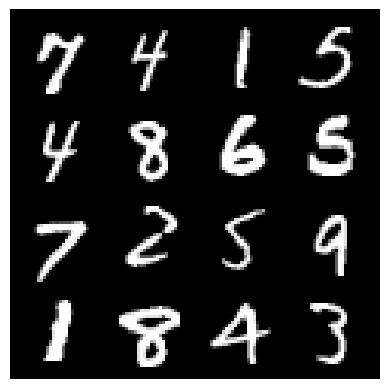

Epoch 25: Step 12000 / Gen loss: 6.539325219790141 / Disc loss: 0.013923411183835334


  0%|          | 0/469 [00:00<?, ?it/s]

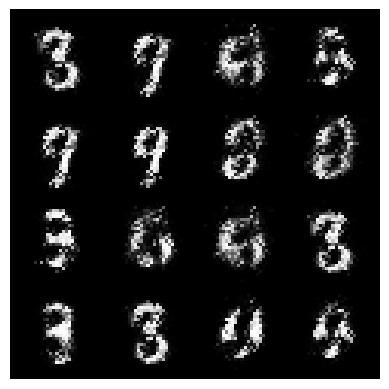

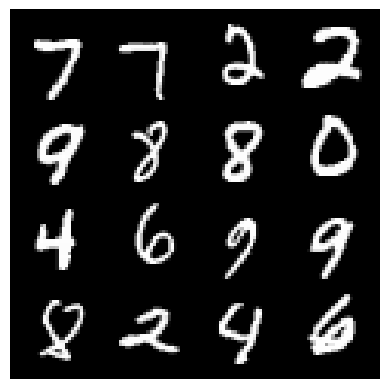

Epoch 26: Step 12300 / Gen loss: 6.437433115641276 / Disc loss: 0.014870462085430827


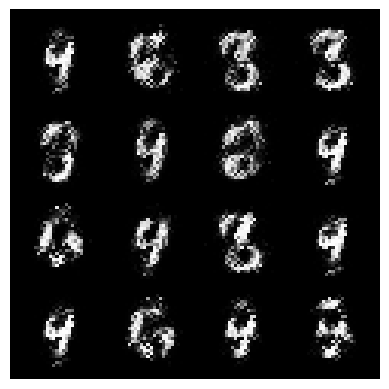

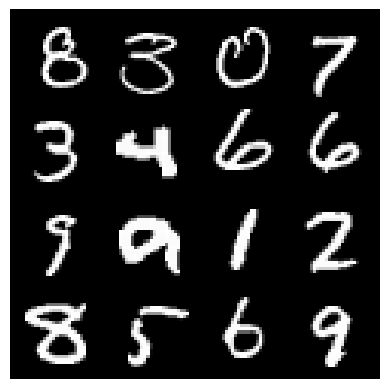

Epoch 26: Step 12600 / Gen loss: 6.3348001797993945 / Disc loss: 0.01716104562083881


  0%|          | 0/469 [00:00<?, ?it/s]

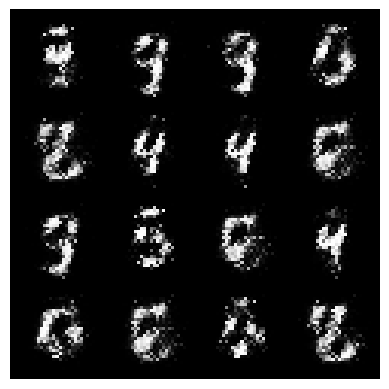

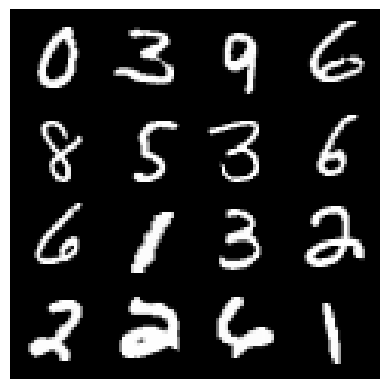

Epoch 27: Step 12900 / Gen loss: 6.500472644170127 / Disc loss: 0.01600336012197659


  0%|          | 0/469 [00:00<?, ?it/s]

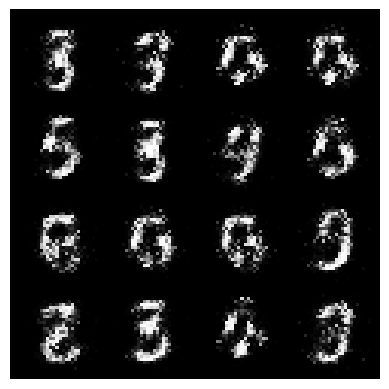

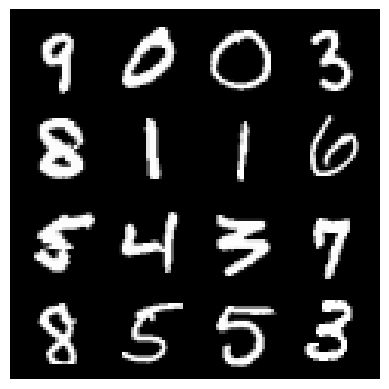

Epoch 28: Step 13200 / Gen loss: 6.472791051864622 / Disc loss: 0.015384916737675672


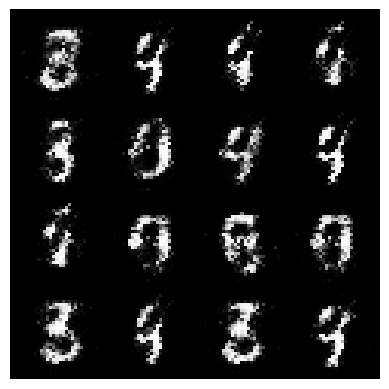

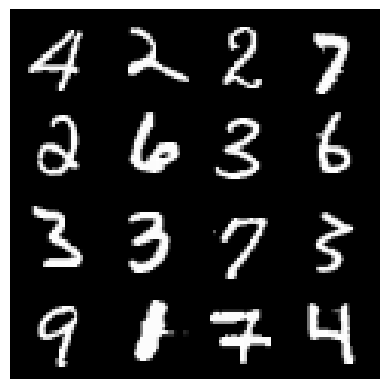

Epoch 28: Step 13500 / Gen loss: 6.677264343897504 / Disc loss: 0.014266897248259436


  0%|          | 0/469 [00:00<?, ?it/s]

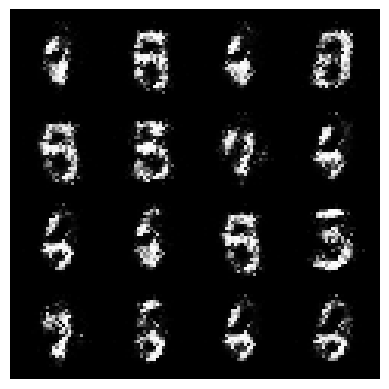

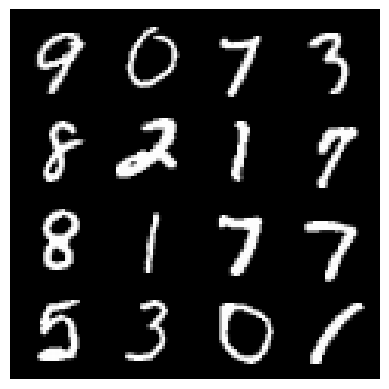

Epoch 29: Step 13800 / Gen loss: 6.27658082167308 / Disc loss: 0.020685269048747918


  0%|          | 0/469 [00:00<?, ?it/s]

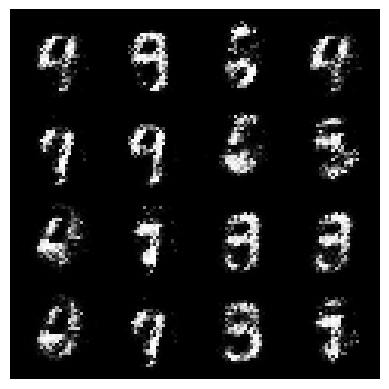

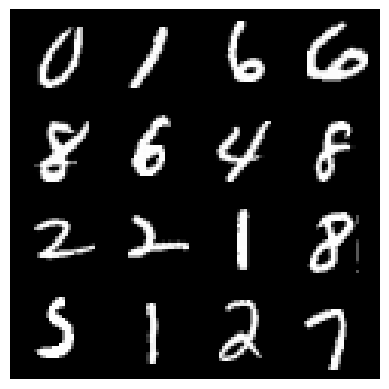

Epoch 30: Step 14100 / Gen loss: 6.346238365173337 / Disc loss: 0.02024305287903795


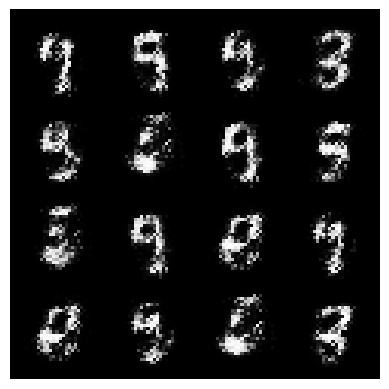

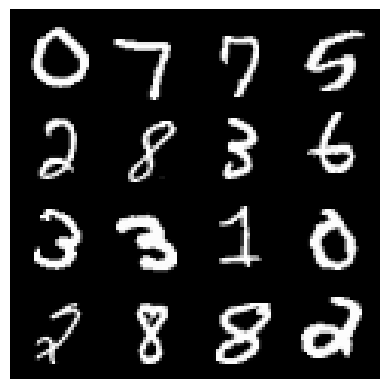

Epoch 30: Step 14400 / Gen loss: 6.830255866050719 / Disc loss: 0.023224869801585255


  0%|          | 0/469 [00:00<?, ?it/s]

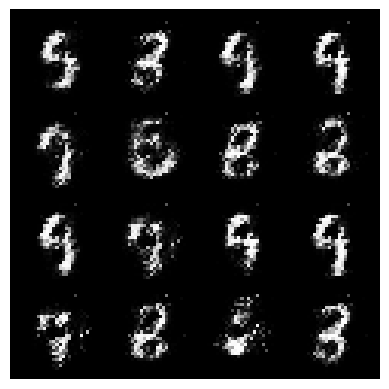

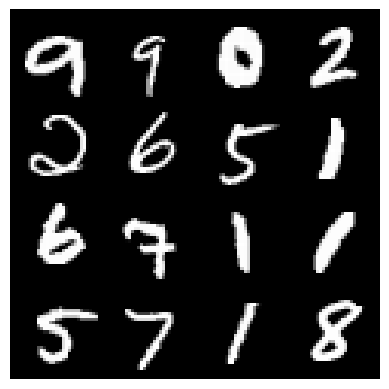

Epoch 31: Step 14700 / Gen loss: 6.7139235273996976 / Disc loss: 0.02006743914913386


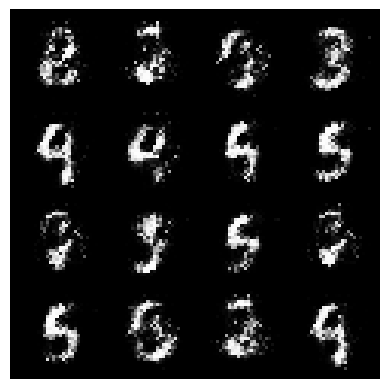

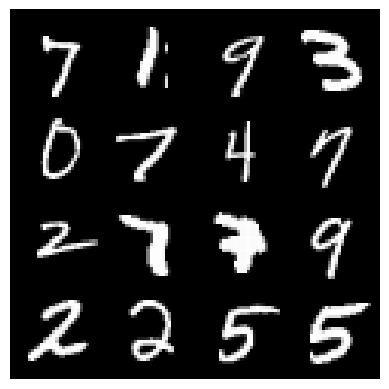

Epoch 31: Step 15000 / Gen loss: 6.622610640525817 / Disc loss: 0.020796119569179906


  0%|          | 0/469 [00:00<?, ?it/s]

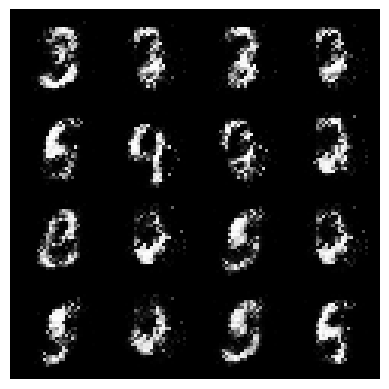

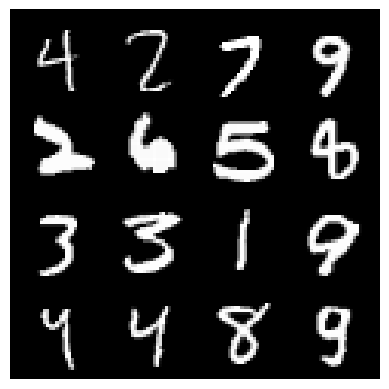

Epoch 32: Step 15300 / Gen loss: 6.55063341935476 / Disc loss: 0.019952759525428226


  0%|          | 0/469 [00:00<?, ?it/s]

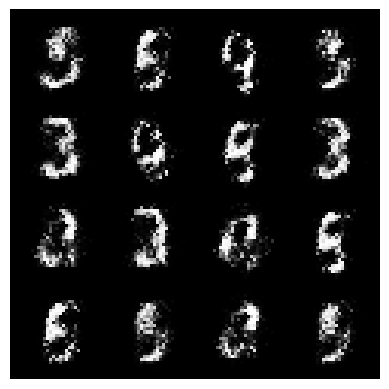

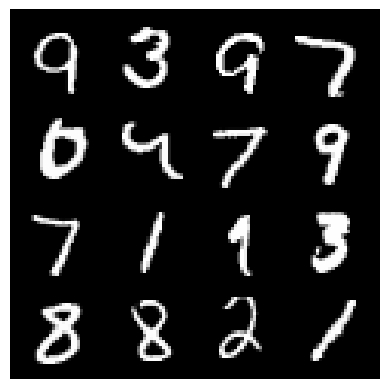

Epoch 33: Step 15600 / Gen loss: 6.631475750605266 / Disc loss: 0.01876207681450372


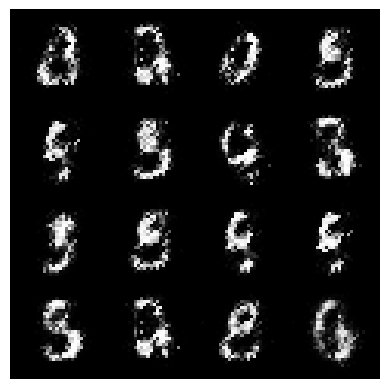

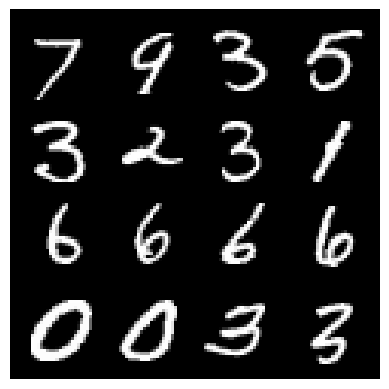

Epoch 33: Step 15900 / Gen loss: 6.538859996795656 / Disc loss: 0.019242635359211502


  0%|          | 0/469 [00:00<?, ?it/s]

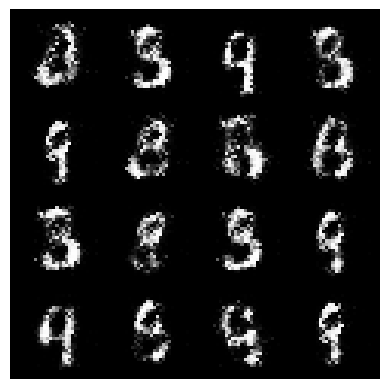

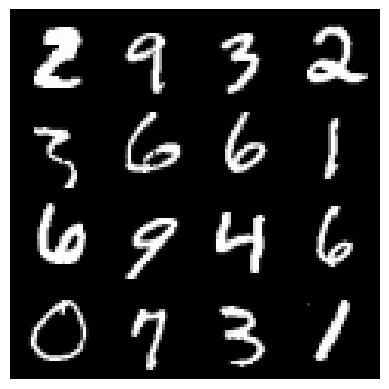

Epoch 34: Step 16200 / Gen loss: 6.7937684551874815 / Disc loss: 0.018478111520331974


  0%|          | 0/469 [00:00<?, ?it/s]

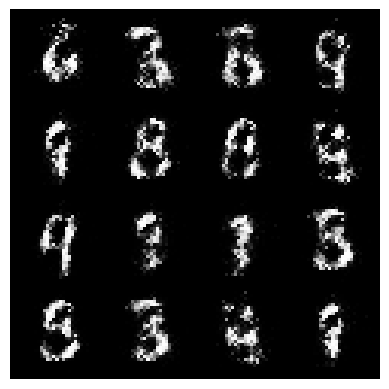

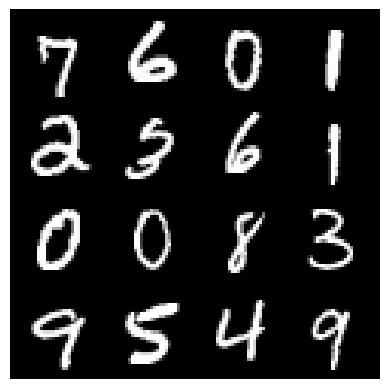

Epoch 35: Step 16500 / Gen loss: 6.805685210227964 / Disc loss: 0.022097770450636753


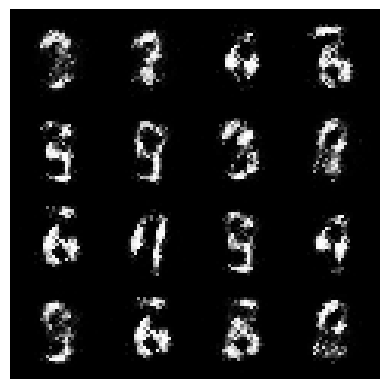

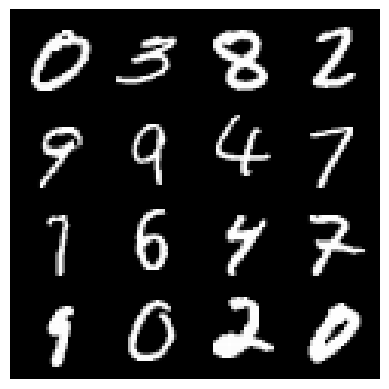

Epoch 35: Step 16800 / Gen loss: 6.445503592491152 / Disc loss: 0.024598922176907453


  0%|          | 0/469 [00:00<?, ?it/s]

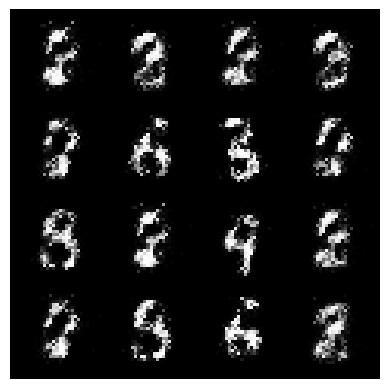

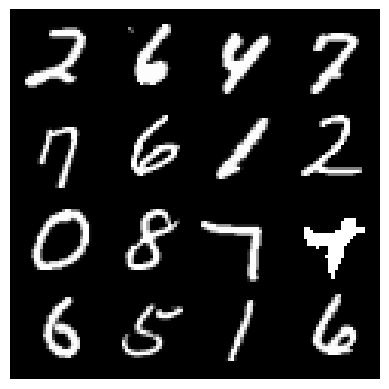

Epoch 36: Step 17100 / Gen loss: 6.361889368693032 / Disc loss: 0.02211419610772282


  0%|          | 0/469 [00:00<?, ?it/s]

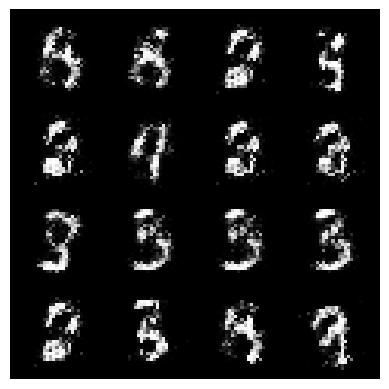

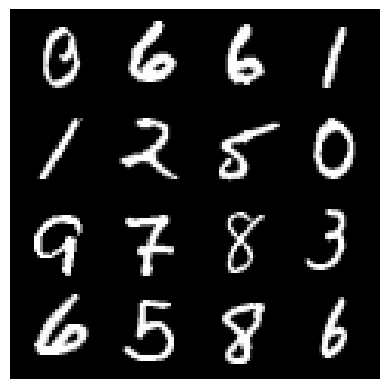

Epoch 37: Step 17400 / Gen loss: 6.661143538157148 / Disc loss: 0.0222372500660519


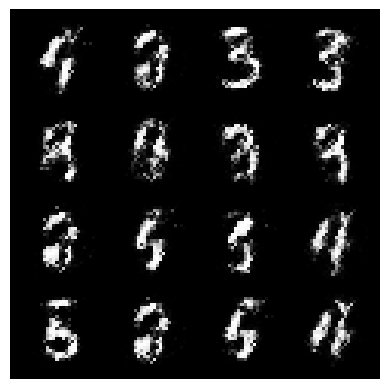

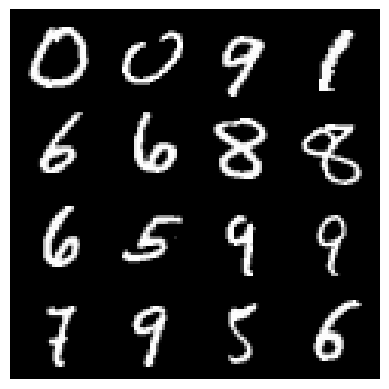

Epoch 37: Step 17700 / Gen loss: 6.189037416776022 / Disc loss: 0.026704266824138647


  0%|          | 0/469 [00:00<?, ?it/s]

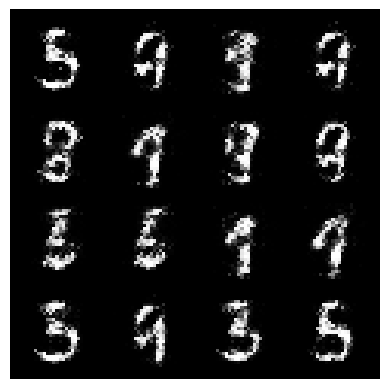

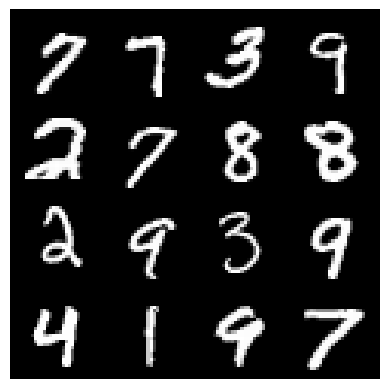

Epoch 38: Step 18000 / Gen loss: 6.322931577364606 / Disc loss: 0.025219739437258488


  0%|          | 0/469 [00:00<?, ?it/s]

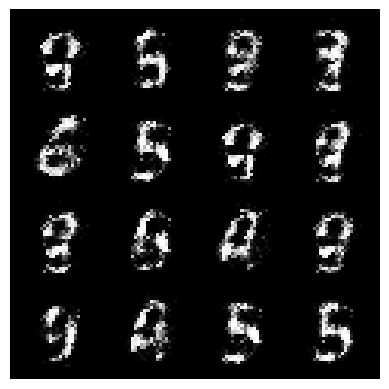

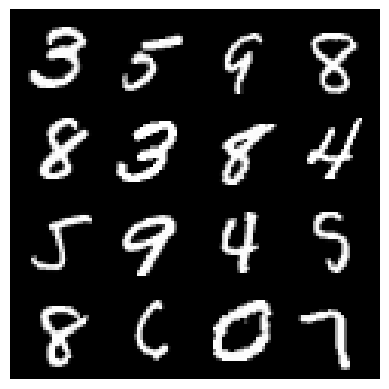

Epoch 39: Step 18300 / Gen loss: 6.483709923426307 / Disc loss: 0.031616911226883516


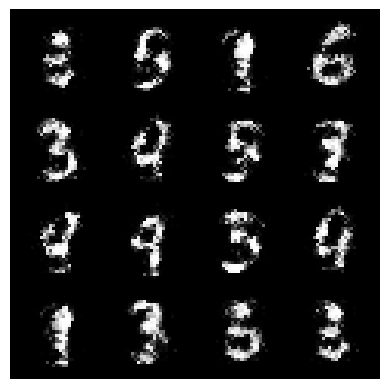

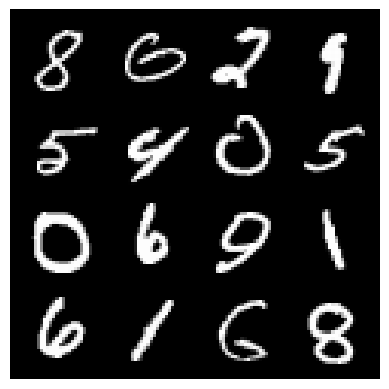

Epoch 39: Step 18600 / Gen loss: 6.093442595799764 / Disc loss: 0.03150423525211711


  0%|          | 0/469 [00:00<?, ?it/s]

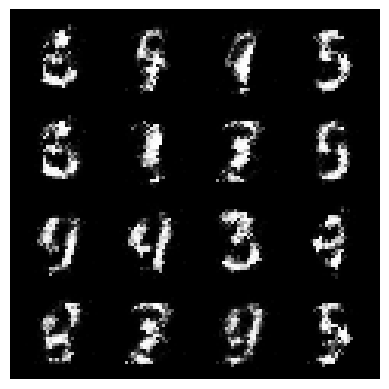

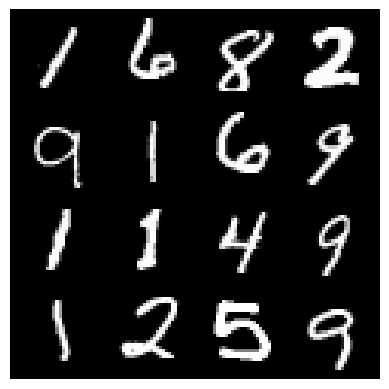

Epoch 40: Step 18900 / Gen loss: 6.285971142450975 / Disc loss: 0.029817346312726555


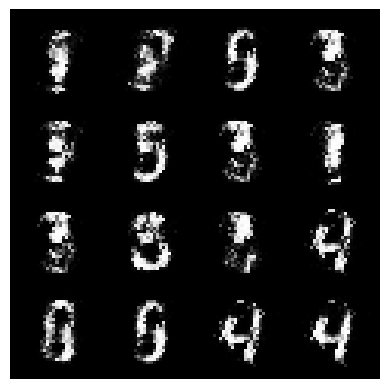

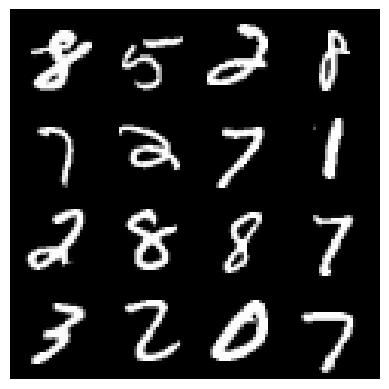

Epoch 40: Step 19200 / Gen loss: 6.3104673099517825 / Disc loss: 0.029040880633207658


  0%|          | 0/469 [00:00<?, ?it/s]

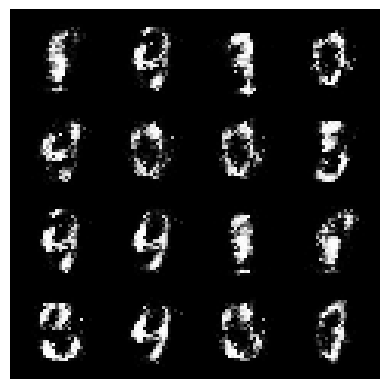

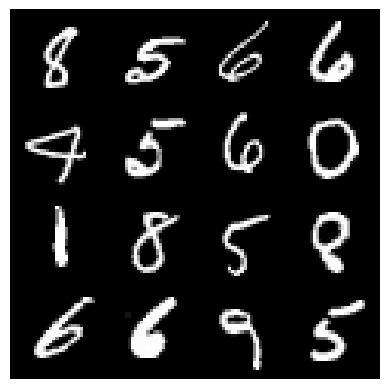

Epoch 41: Step 19500 / Gen loss: 6.169796814918515 / Disc loss: 0.03519055159762504


  0%|          | 0/469 [00:00<?, ?it/s]

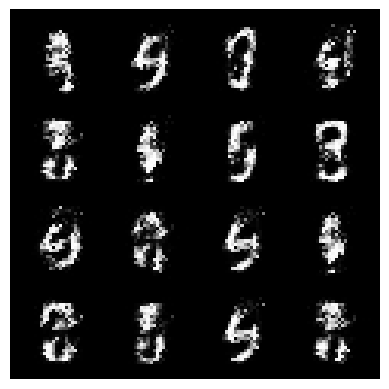

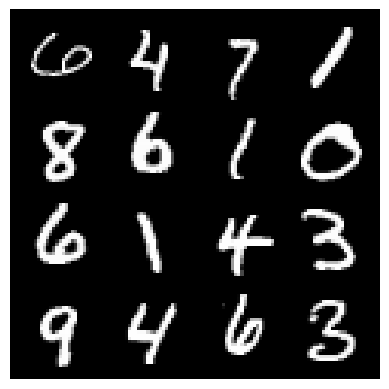

Epoch 42: Step 19800 / Gen loss: 5.983318117459611 / Disc loss: 0.040805286106963955


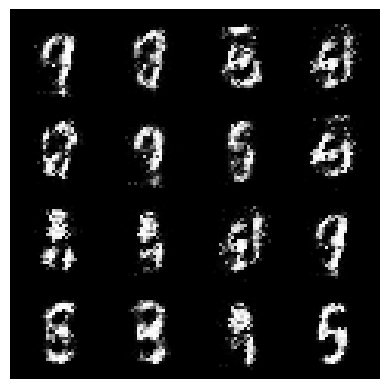

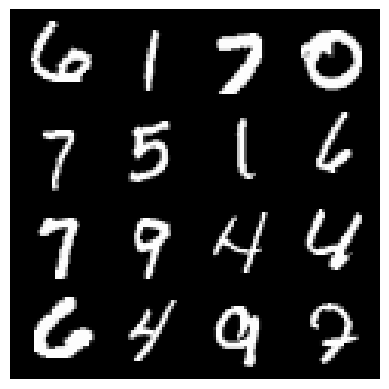

Epoch 42: Step 20100 / Gen loss: 5.968139115969335 / Disc loss: 0.041557812802493585


  0%|          | 0/469 [00:00<?, ?it/s]

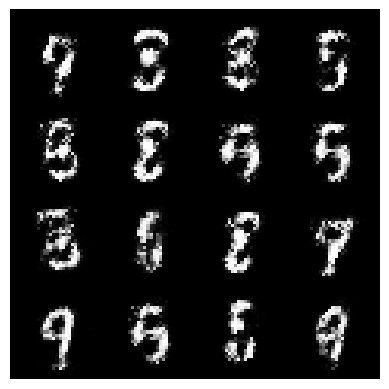

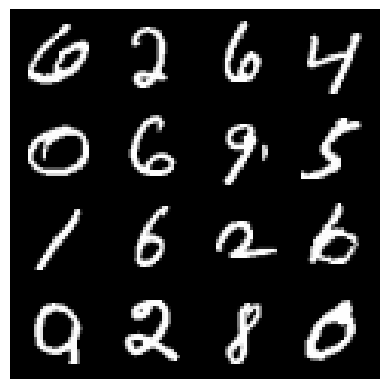

Epoch 43: Step 20400 / Gen loss: 5.934116489092507 / Disc loss: 0.04335805444667737


  0%|          | 0/469 [00:00<?, ?it/s]

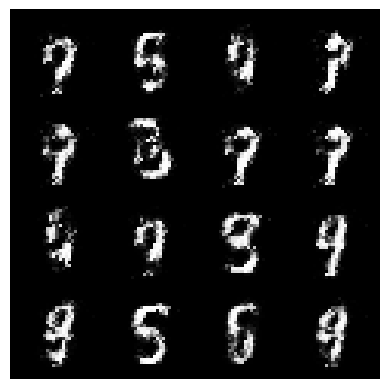

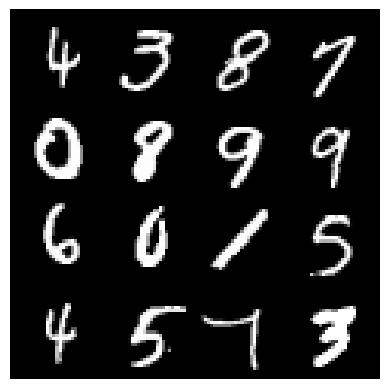

Epoch 44: Step 20700 / Gen loss: 5.497925511201222 / Disc loss: 0.04689884063166878


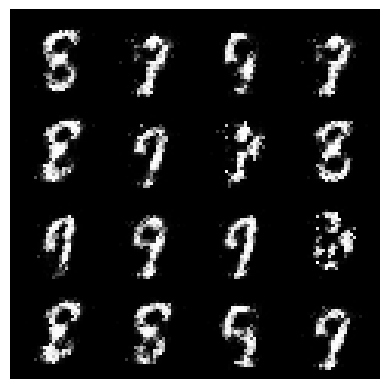

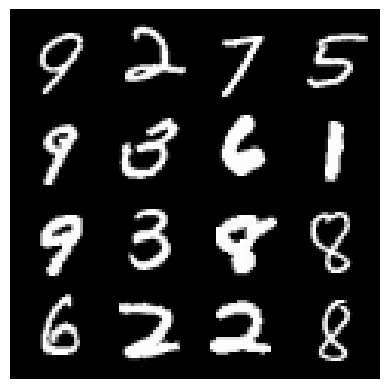

Epoch 44: Step 21000 / Gen loss: 5.322428649266557 / Disc loss: 0.04090055238145092


  0%|          | 0/469 [00:00<?, ?it/s]

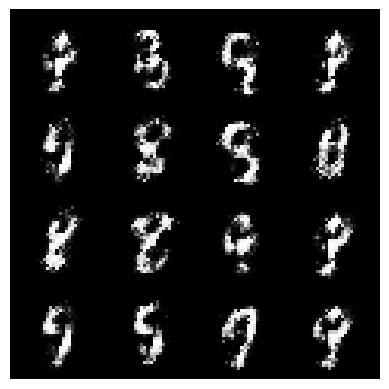

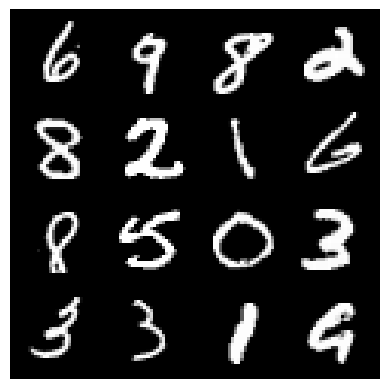

Epoch 45: Step 21300 / Gen loss: 5.65466165065766 / Disc loss: 0.03686605771072211


  0%|          | 0/469 [00:00<?, ?it/s]

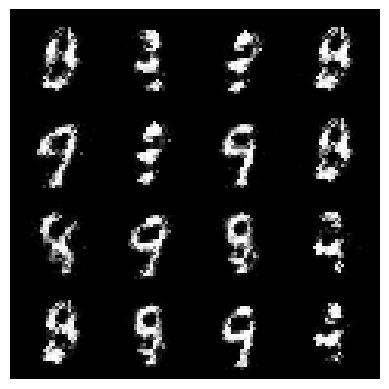

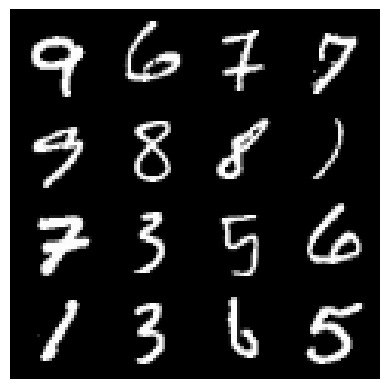

Epoch 46: Step 21600 / Gen loss: 5.650770279566449 / Disc loss: 0.0421501917919765


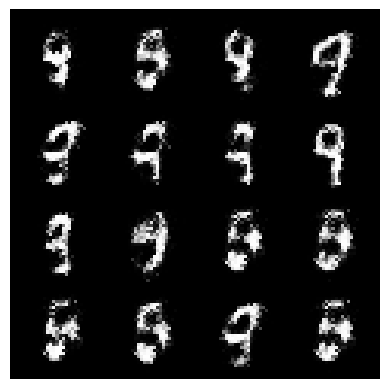

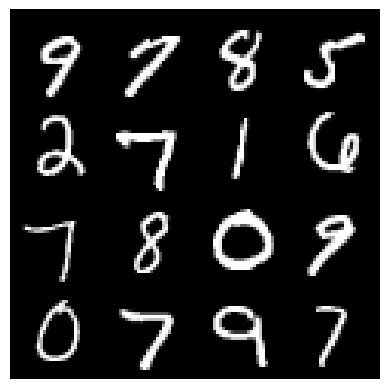

Epoch 46: Step 21900 / Gen loss: 5.477266738414767 / Disc loss: 0.056815526451294604


  0%|          | 0/469 [00:00<?, ?it/s]

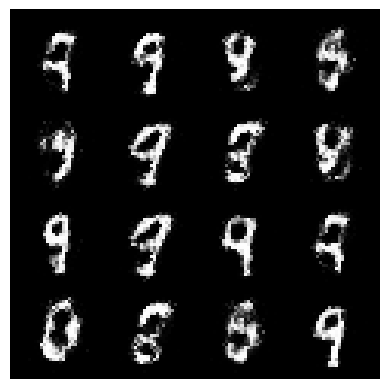

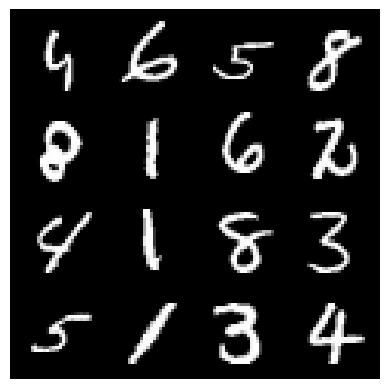

Epoch 47: Step 22200 / Gen loss: 5.474007312456766 / Disc loss: 0.06277098783912764


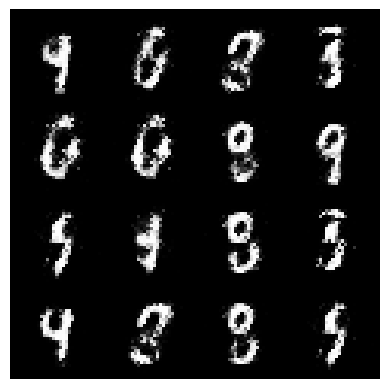

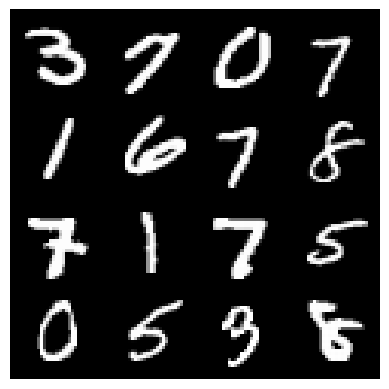

Epoch 47: Step 22500 / Gen loss: 5.519913674990337 / Disc loss: 0.0606140973667304


  0%|          | 0/469 [00:00<?, ?it/s]

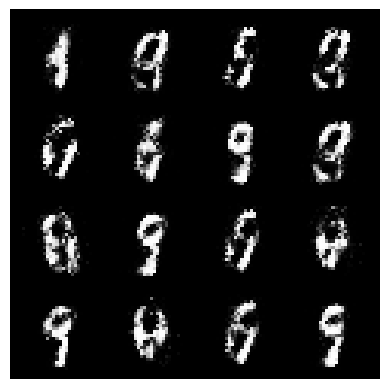

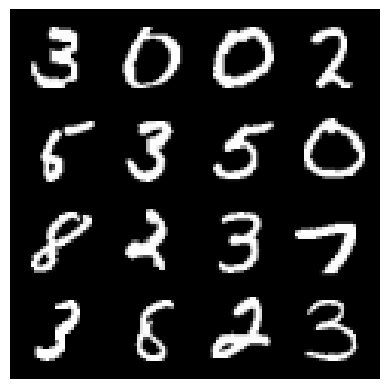

Epoch 48: Step 22800 / Gen loss: 5.455448149045306 / Disc loss: 0.05753370678362743


  0%|          | 0/469 [00:00<?, ?it/s]

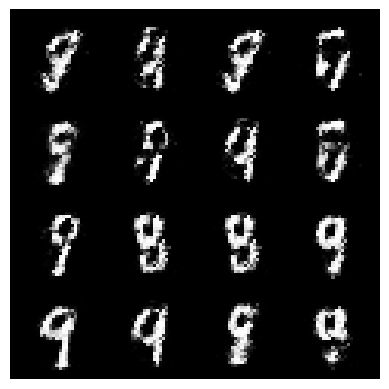

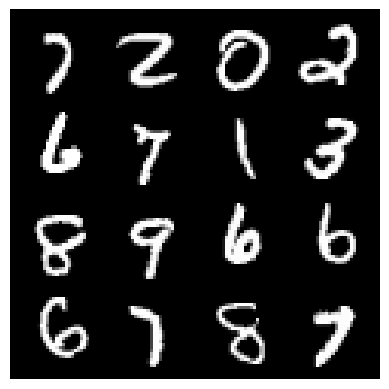

Epoch 49: Step 23100 / Gen loss: 5.4253823566436745 / Disc loss: 0.05587067687107876


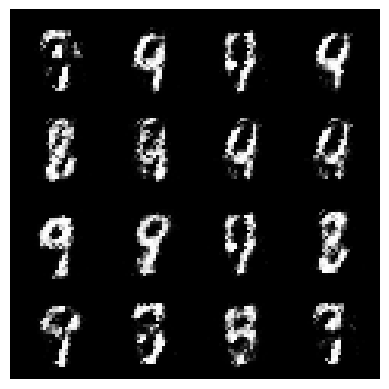

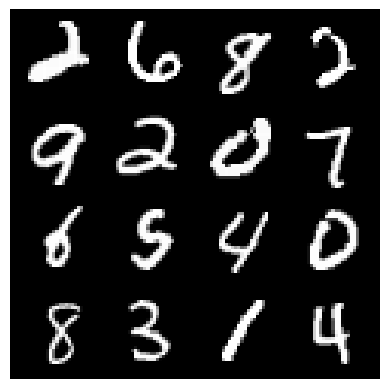

Epoch 49: Step 23400 / Gen loss: 5.223867781956994 / Disc loss: 0.06685703357681631


  0%|          | 0/469 [00:00<?, ?it/s]

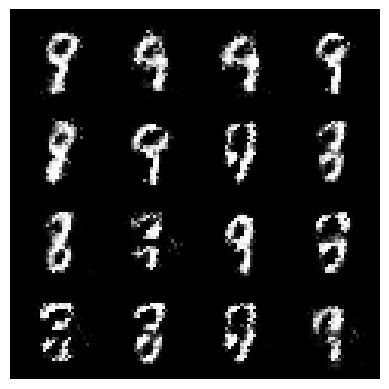

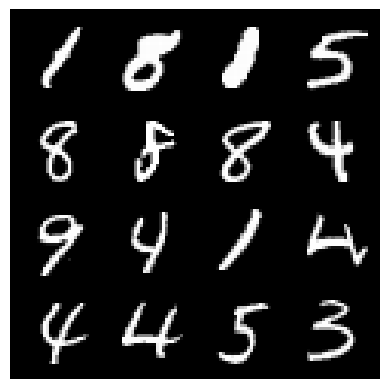

Epoch 50: Step 23700 / Gen loss: 4.953034915924075 / Disc loss: 0.08003583230078228


  0%|          | 0/469 [00:00<?, ?it/s]

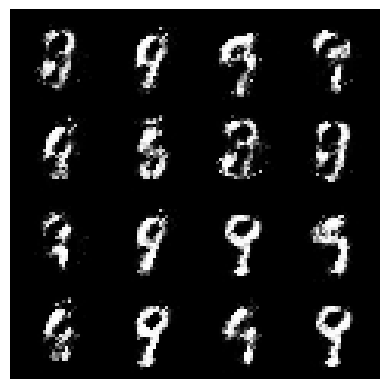

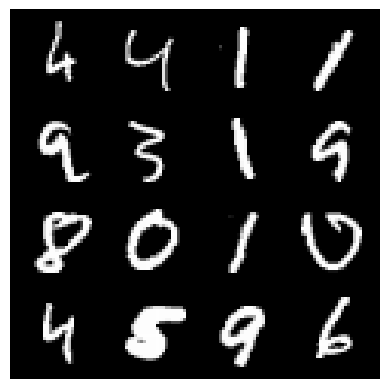

Epoch 51: Step 24000 / Gen loss: 4.971838063398999 / Disc loss: 0.06786563759048775


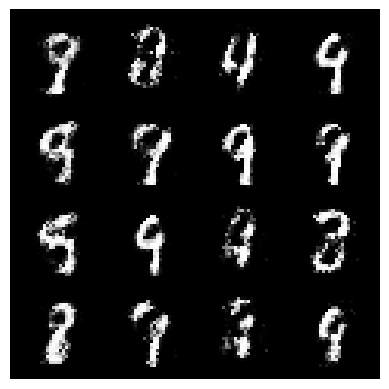

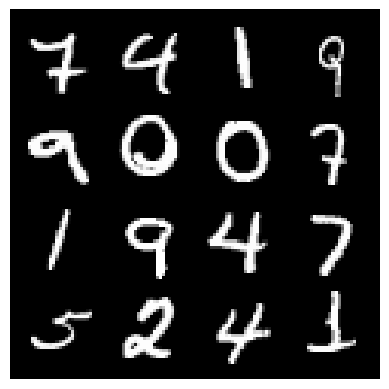

Epoch 51: Step 24300 / Gen loss: 5.059391616185509 / Disc loss: 0.06588477335249385


  0%|          | 0/469 [00:00<?, ?it/s]

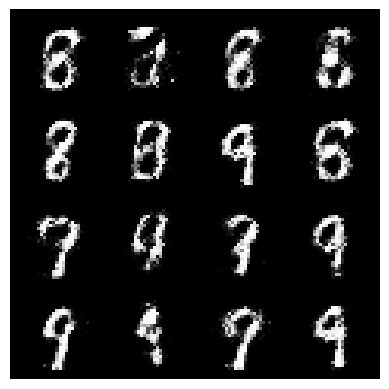

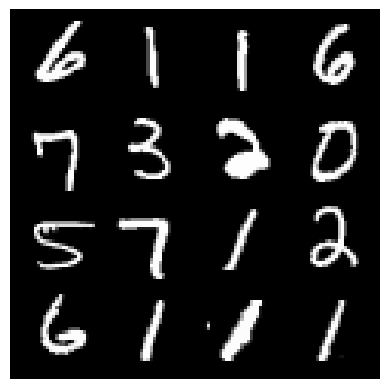

Epoch 52: Step 24600 / Gen loss: 5.078425151507055 / Disc loss: 0.0724183023596803


  0%|          | 0/469 [00:00<?, ?it/s]

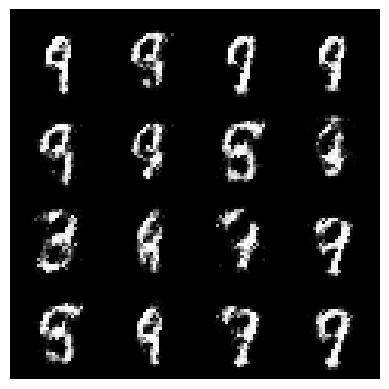

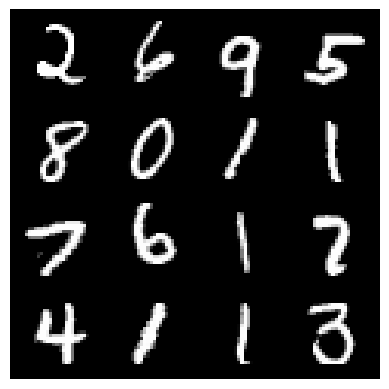

Epoch 53: Step 24900 / Gen loss: 4.872336750030519 / Disc loss: 0.07118027995030085


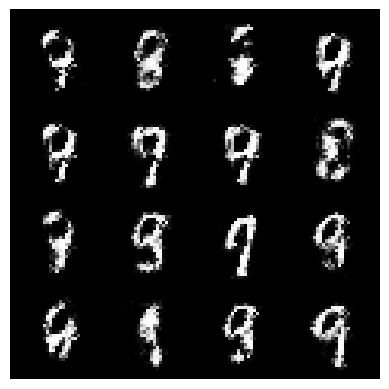

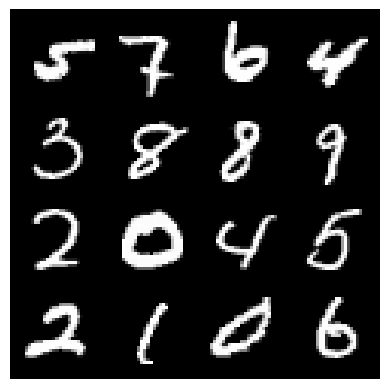

Epoch 53: Step 25200 / Gen loss: 4.894807229042054 / Disc loss: 0.06511405459294718


  0%|          | 0/469 [00:00<?, ?it/s]

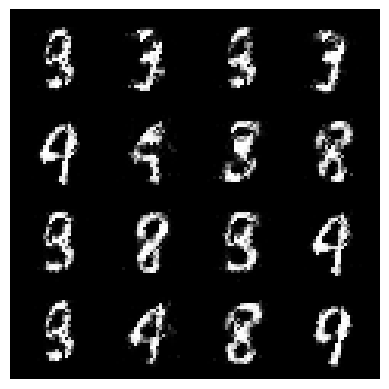

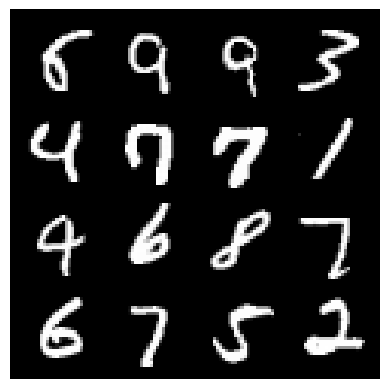

Epoch 54: Step 25500 / Gen loss: 5.035820398330686 / Disc loss: 0.06759256580844523


  0%|          | 0/469 [00:00<?, ?it/s]

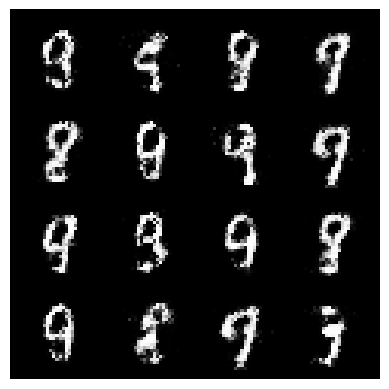

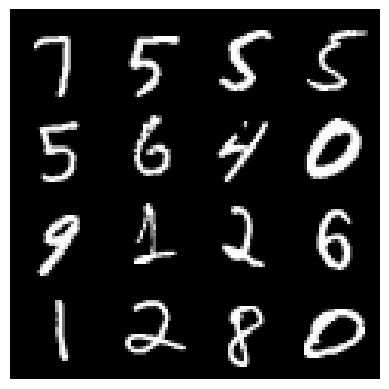

Epoch 55: Step 25800 / Gen loss: 4.8230439686775215 / Disc loss: 0.07030406939486665


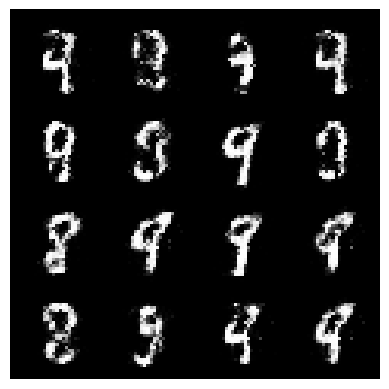

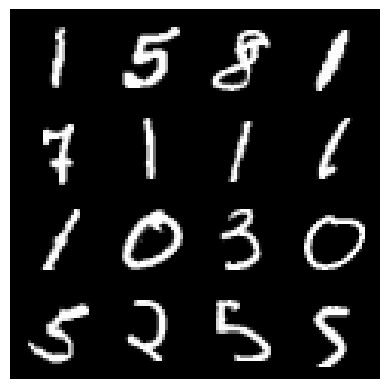

Epoch 55: Step 26100 / Gen loss: 4.751262177626295 / Disc loss: 0.07158806734407944


  0%|          | 0/469 [00:00<?, ?it/s]

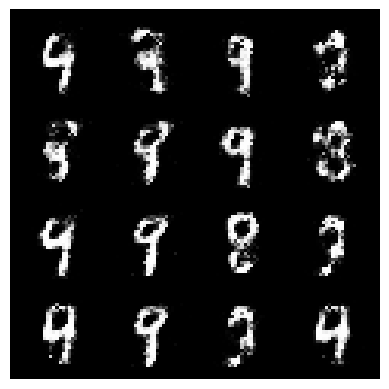

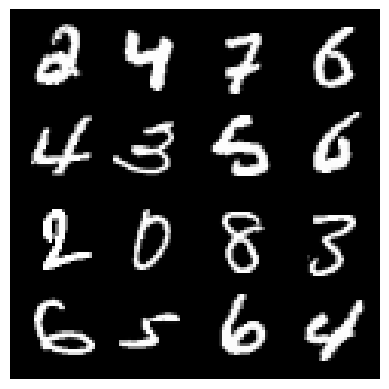

Epoch 56: Step 26400 / Gen loss: 4.665352865854901 / Disc loss: 0.08008285393317544


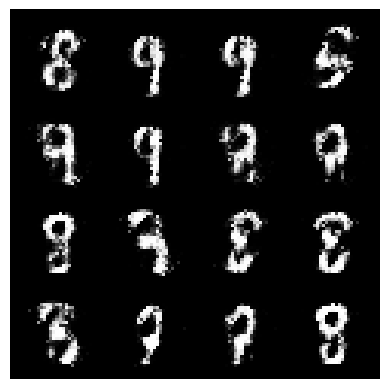

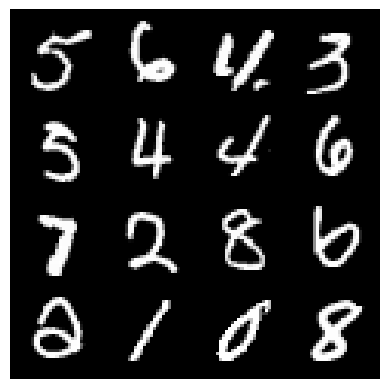

Epoch 56: Step 26700 / Gen loss: 4.616090488433835 / Disc loss: 0.0872166951186955


  0%|          | 0/469 [00:00<?, ?it/s]

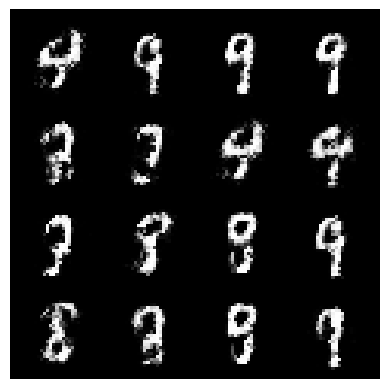

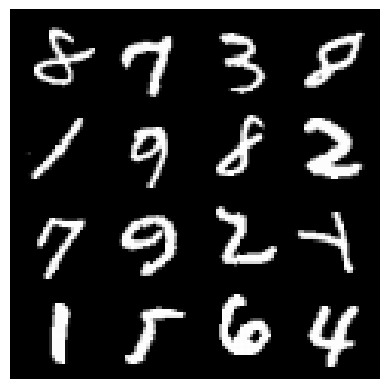

Epoch 57: Step 27000 / Gen loss: 4.647446655432384 / Disc loss: 0.0827063450900217


  0%|          | 0/469 [00:00<?, ?it/s]

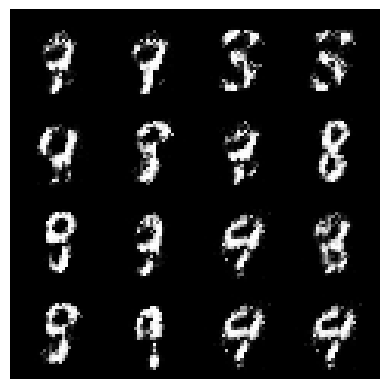

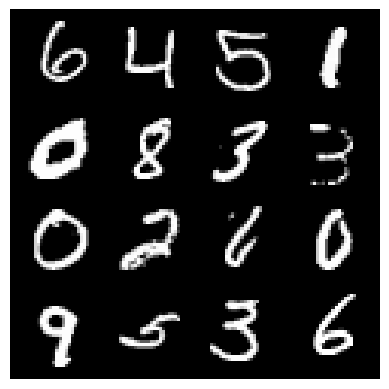

Epoch 58: Step 27300 / Gen loss: 4.688895337581638 / Disc loss: 0.07404058807219066


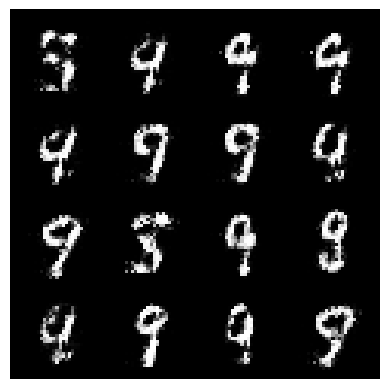

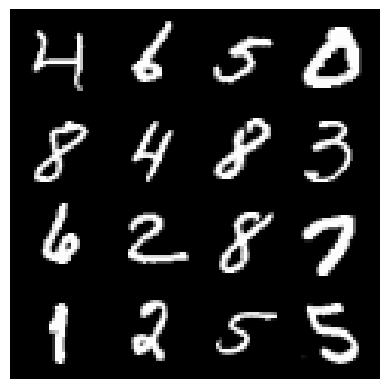

Epoch 58: Step 27600 / Gen loss: 4.403018846511841 / Disc loss: 0.0808066537852088


  0%|          | 0/469 [00:00<?, ?it/s]

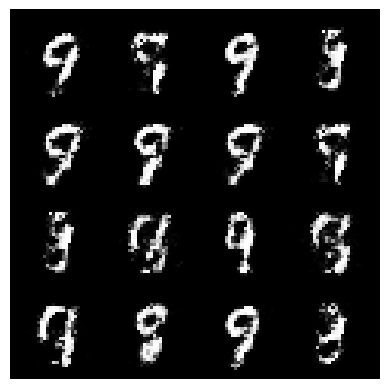

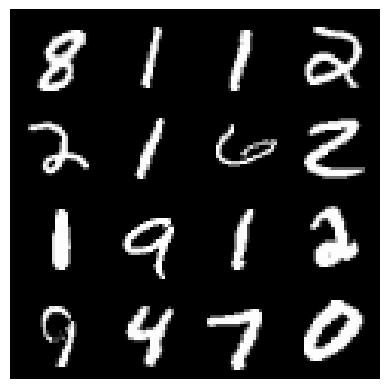

Epoch 59: Step 27900 / Gen loss: 4.457827181816101 / Disc loss: 0.08429923607036474


  0%|          | 0/469 [00:00<?, ?it/s]

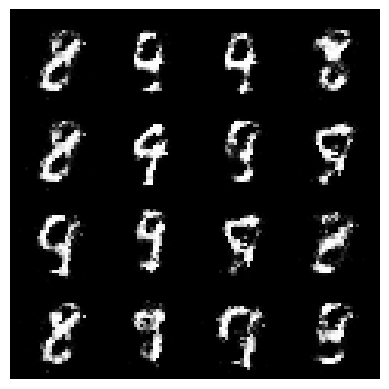

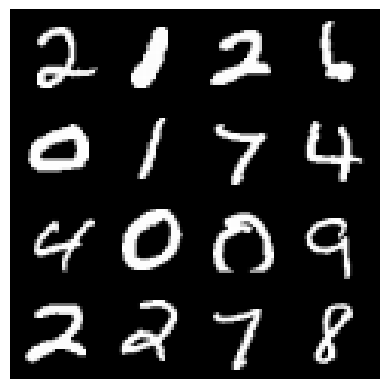

Epoch 60: Step 28200 / Gen loss: 4.483608168760935 / Disc loss: 0.07484336244563261


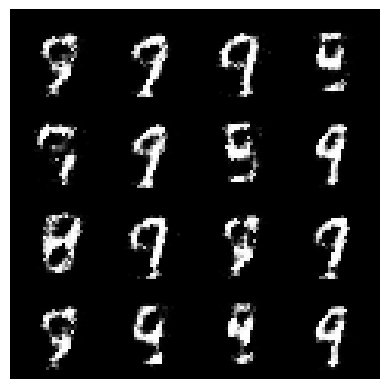

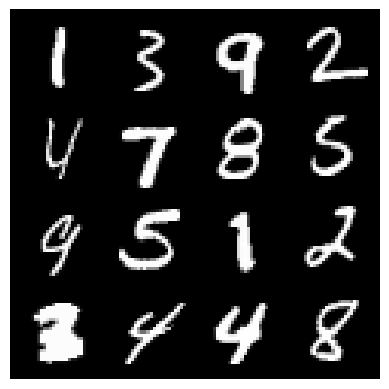

Epoch 60: Step 28500 / Gen loss: 4.322938806215923 / Disc loss: 0.08833145392437772


  0%|          | 0/469 [00:00<?, ?it/s]

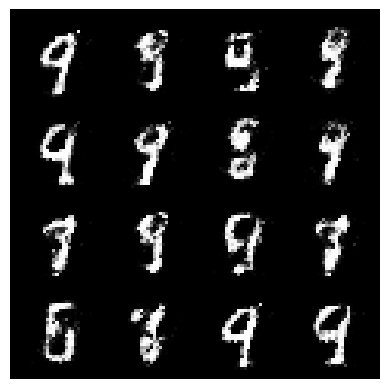

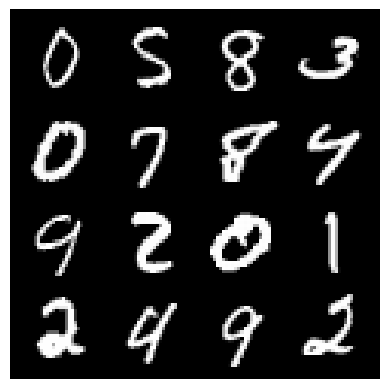

Epoch 61: Step 28800 / Gen loss: 4.264938596884411 / Disc loss: 0.08383892329409715


  0%|          | 0/469 [00:00<?, ?it/s]

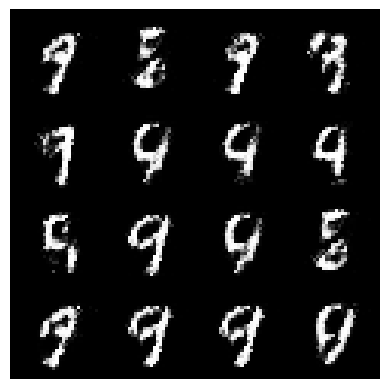

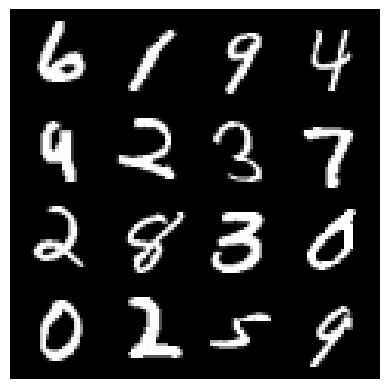

Epoch 62: Step 29100 / Gen loss: 4.464368545214333 / Disc loss: 0.08656322211027147


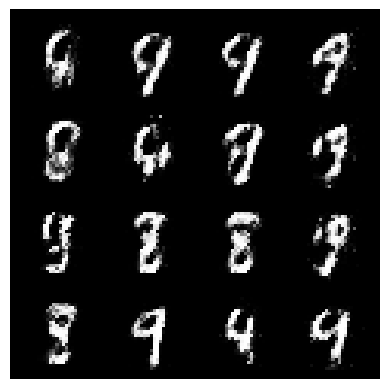

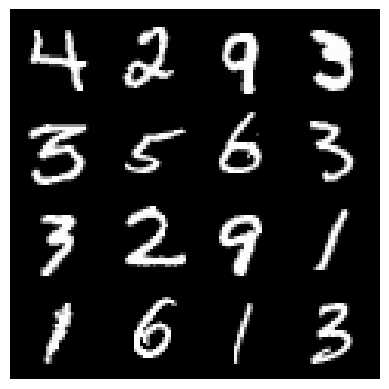

Epoch 62: Step 29400 / Gen loss: 4.155597573121388 / Disc loss: 0.08830954298997915


  0%|          | 0/469 [00:00<?, ?it/s]

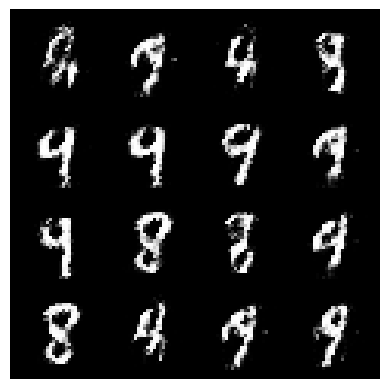

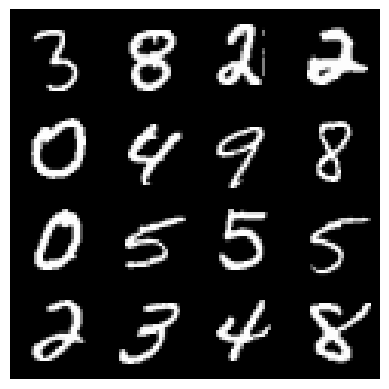

Epoch 63: Step 29700 / Gen loss: 4.13125101327896 / Disc loss: 0.08594713830699527


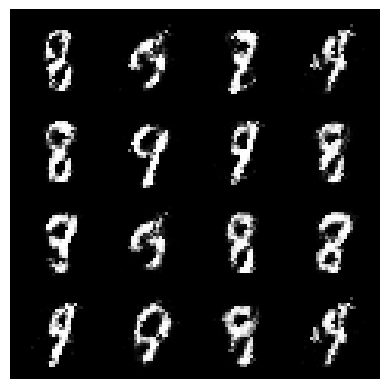

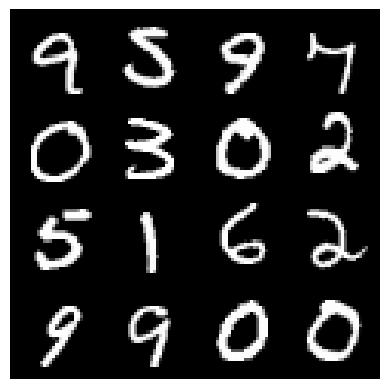

Epoch 63: Step 30000 / Gen loss: 4.352012564341224 / Disc loss: 0.0795749118737877


  0%|          | 0/469 [00:00<?, ?it/s]

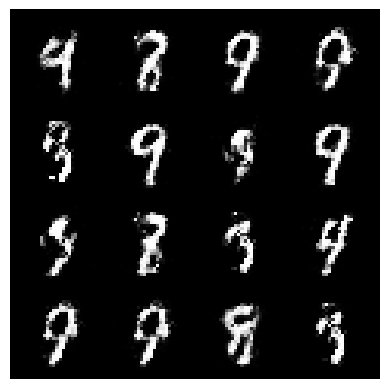

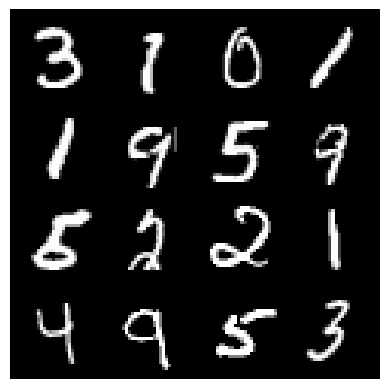

Epoch 64: Step 30300 / Gen loss: 4.422891649405164 / Disc loss: 0.08073474180574218


  0%|          | 0/469 [00:00<?, ?it/s]

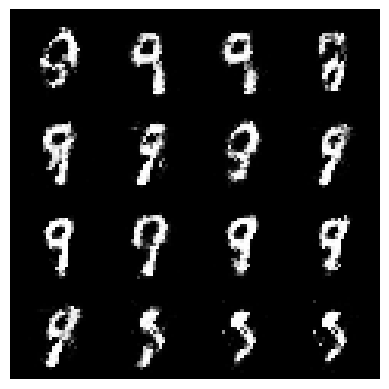

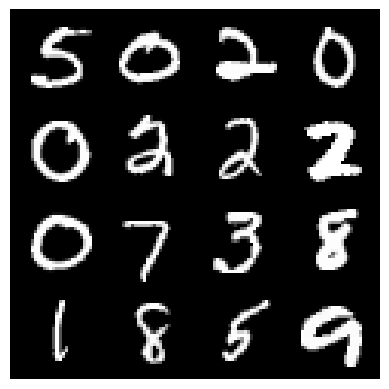

Epoch 65: Step 30600 / Gen loss: 4.547256595293679 / Disc loss: 0.07844267345344025


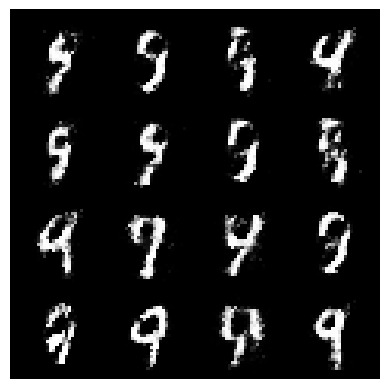

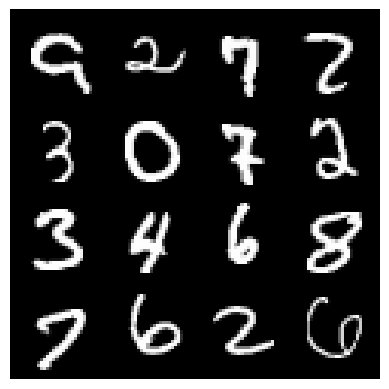

Epoch 65: Step 30900 / Gen loss: 4.359427674611409 / Disc loss: 0.09726675593604647


  0%|          | 0/469 [00:00<?, ?it/s]

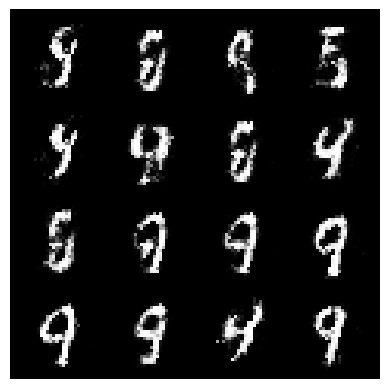

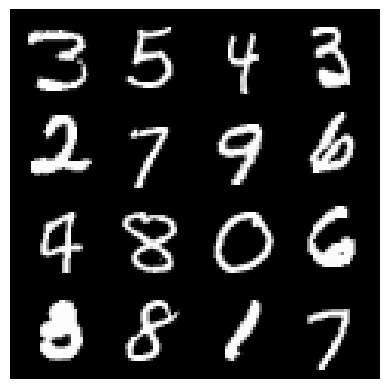

Epoch 66: Step 31200 / Gen loss: 4.132667352358499 / Disc loss: 0.09675039006397135


  0%|          | 0/469 [00:00<?, ?it/s]

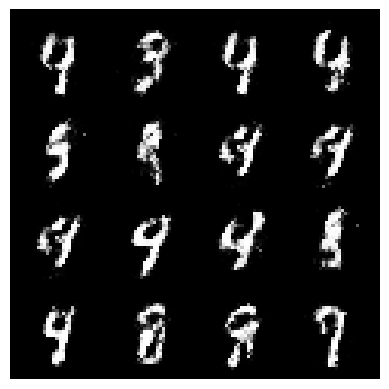

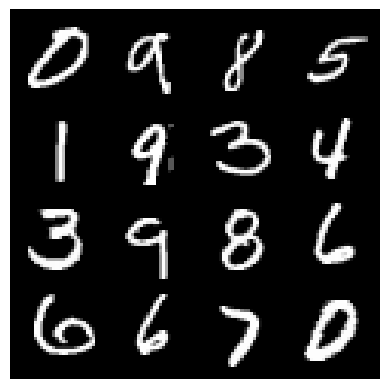

Epoch 67: Step 31500 / Gen loss: 4.178188369274138 / Disc loss: 0.10709133495887119


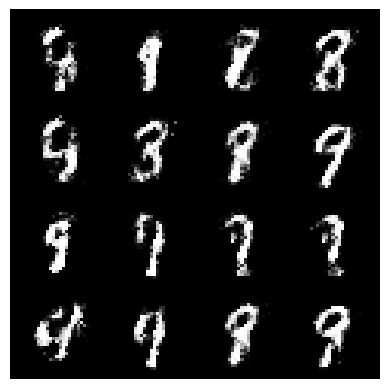

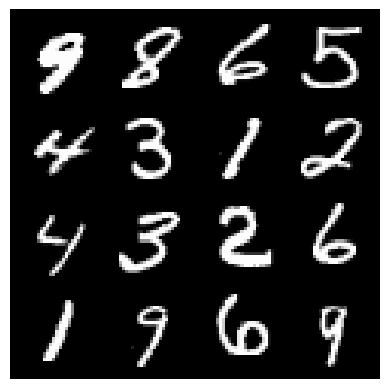

Epoch 67: Step 31800 / Gen loss: 3.8425604406992586 / Disc loss: 0.11590624543527765


  0%|          | 0/469 [00:00<?, ?it/s]

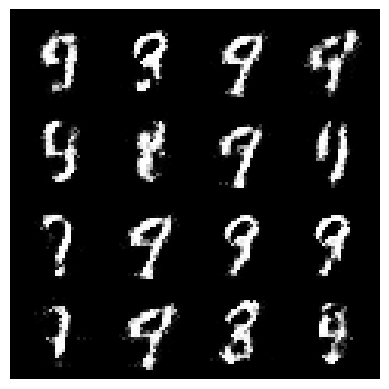

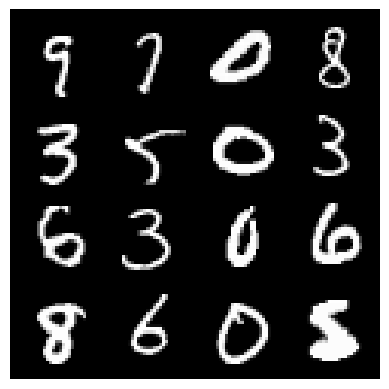

Epoch 68: Step 32100 / Gen loss: 3.8452661244074506 / Disc loss: 0.10605563965936501


  0%|          | 0/469 [00:00<?, ?it/s]

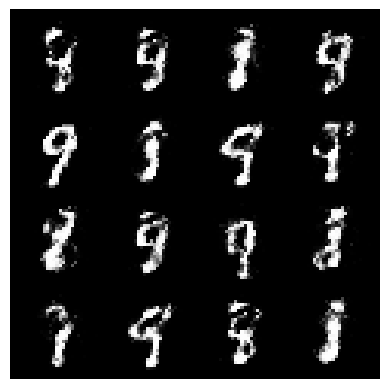

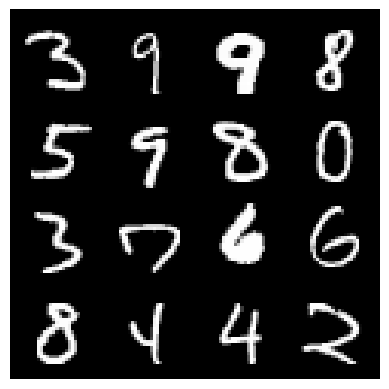

Epoch 69: Step 32400 / Gen loss: 4.087471621036527 / Disc loss: 0.1001401157552997


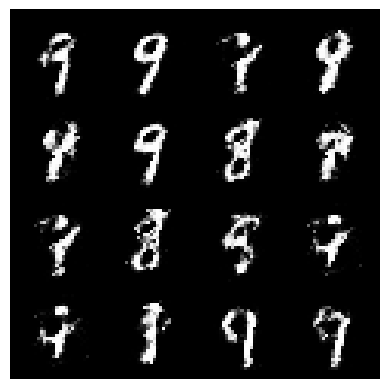

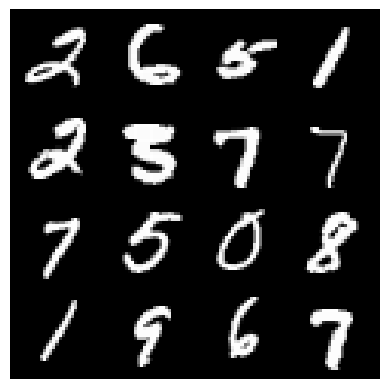

Epoch 69: Step 32700 / Gen loss: 4.030756115118663 / Disc loss: 0.1084622992450992


  0%|          | 0/469 [00:00<?, ?it/s]

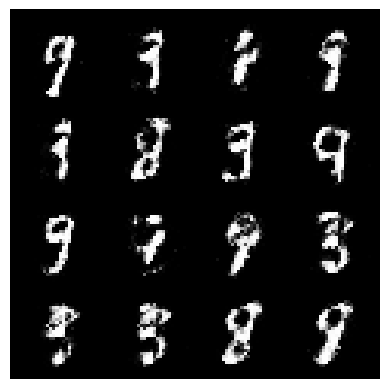

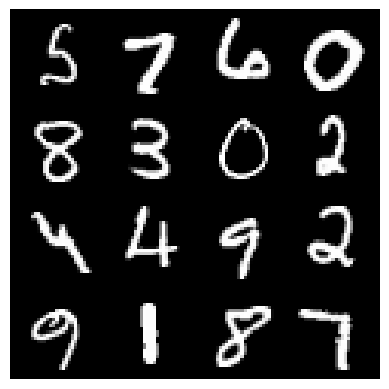

Epoch 70: Step 33000 / Gen loss: 3.876766638755796 / Disc loss: 0.11741019848734136


  0%|          | 0/469 [00:00<?, ?it/s]

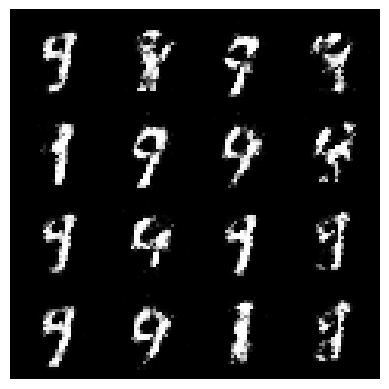

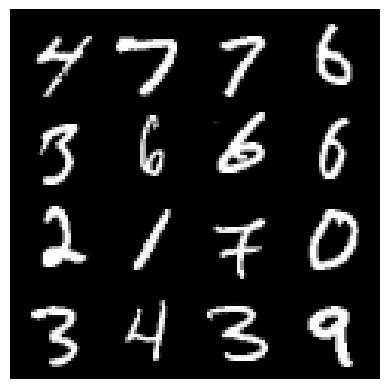

Epoch 71: Step 33300 / Gen loss: 3.856068890889484 / Disc loss: 0.12304868822296464


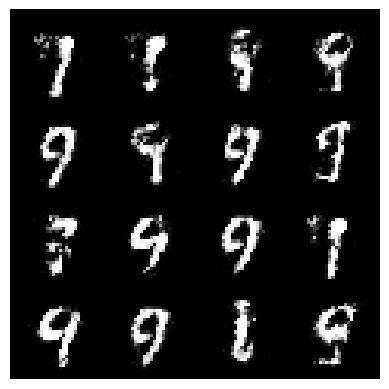

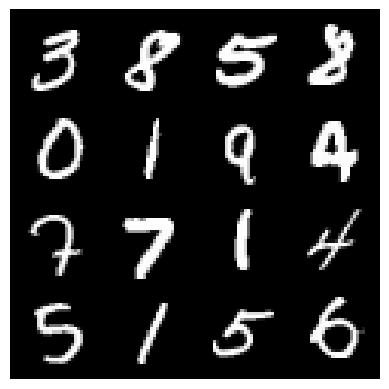

Epoch 71: Step 33600 / Gen loss: 3.7584672705332447 / Disc loss: 0.1255122740442554


  0%|          | 0/469 [00:00<?, ?it/s]

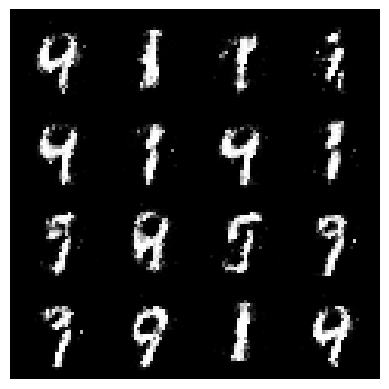

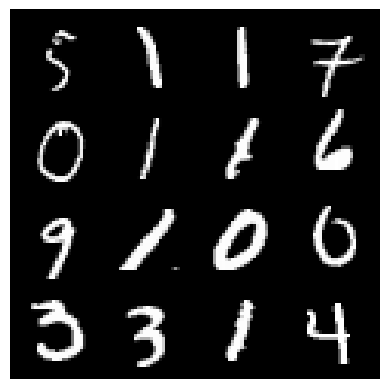

Epoch 72: Step 33900 / Gen loss: 3.875541245937346 / Disc loss: 0.09956140775233513


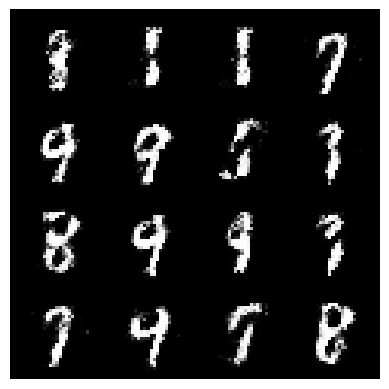

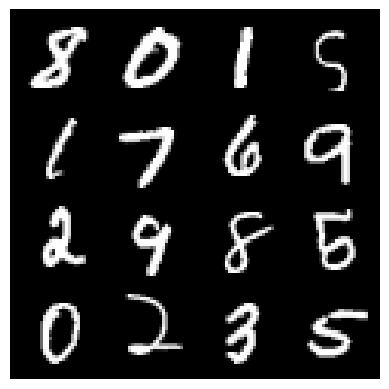

Epoch 72: Step 34200 / Gen loss: 3.9037076481183406 / Disc loss: 0.10471707414835696


  0%|          | 0/469 [00:00<?, ?it/s]

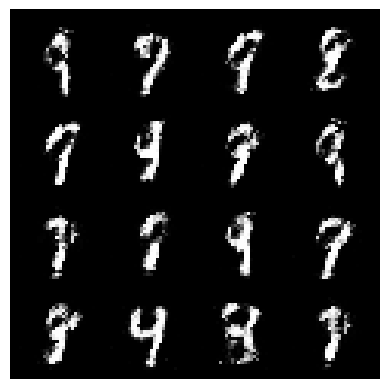

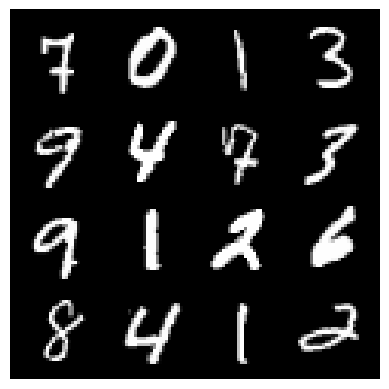

Epoch 73: Step 34500 / Gen loss: 3.8226855548222844 / Disc loss: 0.11523746622105441


  0%|          | 0/469 [00:00<?, ?it/s]

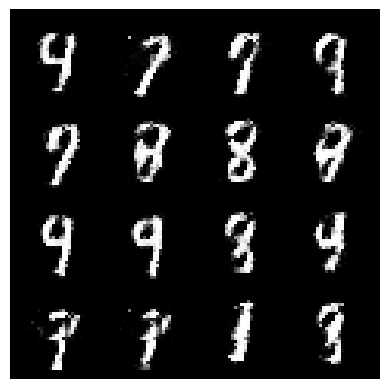

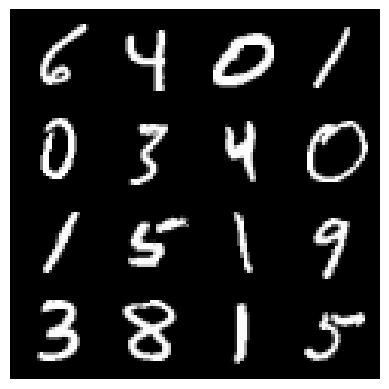

Epoch 74: Step 34800 / Gen loss: 3.7072809648513796 / Disc loss: 0.13497641210754707


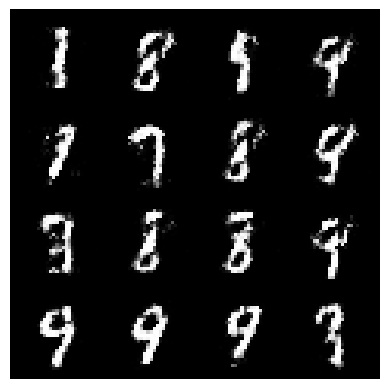

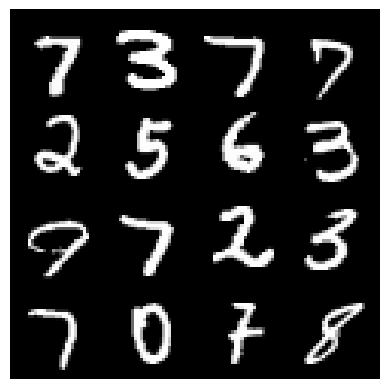

Epoch 74: Step 35100 / Gen loss: 3.659651431242624 / Disc loss: 0.13329234356681516


  0%|          | 0/469 [00:00<?, ?it/s]

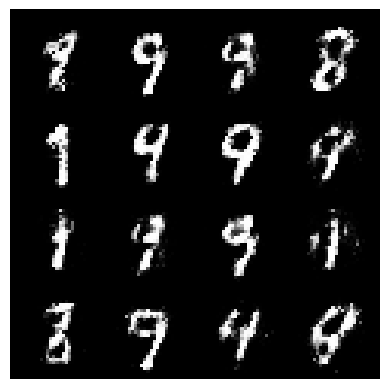

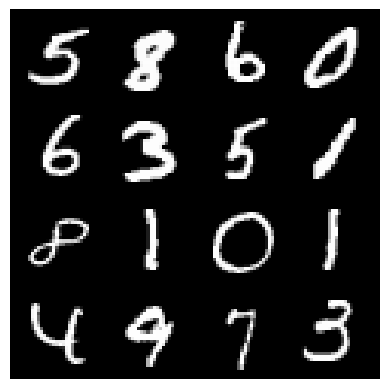

Epoch 75: Step 35400 / Gen loss: 3.4353290780385355 / Disc loss: 0.143135739415884


  0%|          | 0/469 [00:00<?, ?it/s]

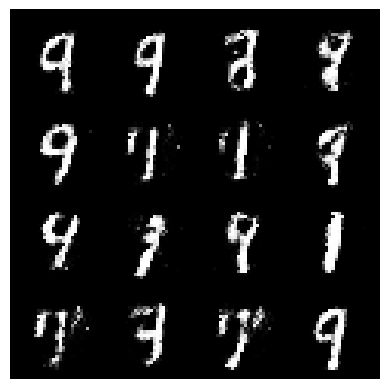

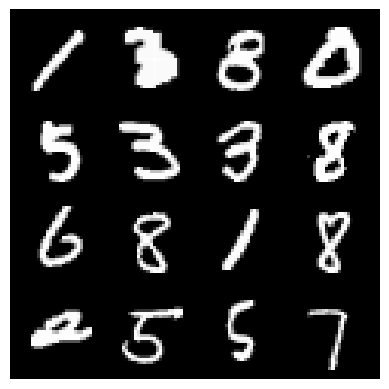

Epoch 76: Step 35700 / Gen loss: 3.4460731784502654 / Disc loss: 0.15522035263478764


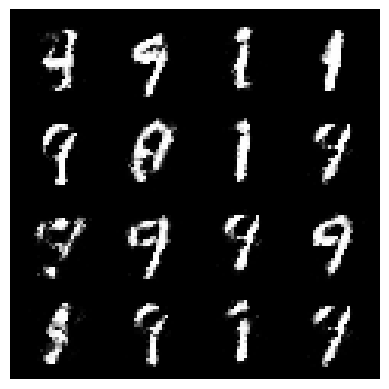

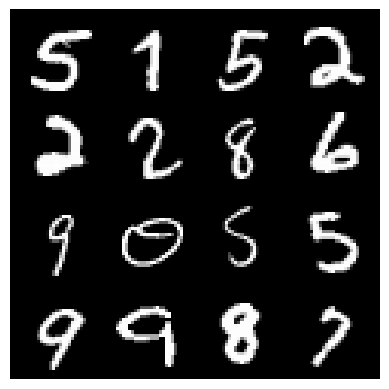

Epoch 76: Step 36000 / Gen loss: 3.3741011055310586 / Disc loss: 0.1594040550291539


  0%|          | 0/469 [00:00<?, ?it/s]

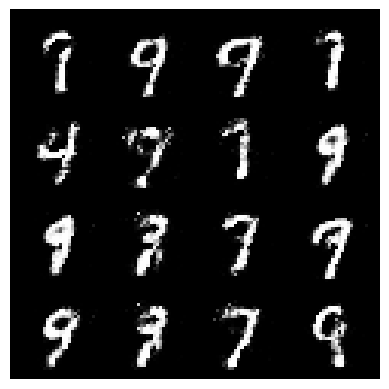

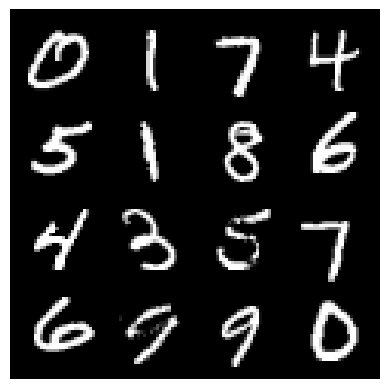

Epoch 77: Step 36300 / Gen loss: 3.338149199485779 / Disc loss: 0.14409175485372538


  0%|          | 0/469 [00:00<?, ?it/s]

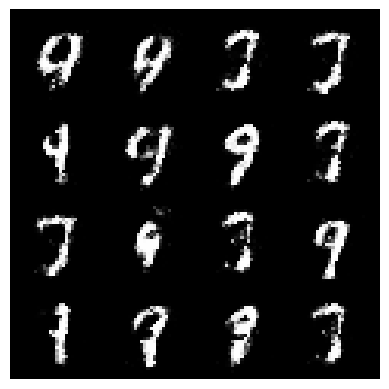

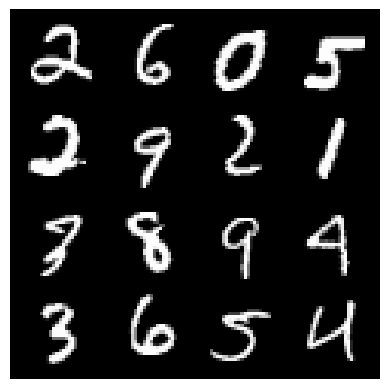

Epoch 78: Step 36600 / Gen loss: 3.4720070703824395 / Disc loss: 0.13640108735611037


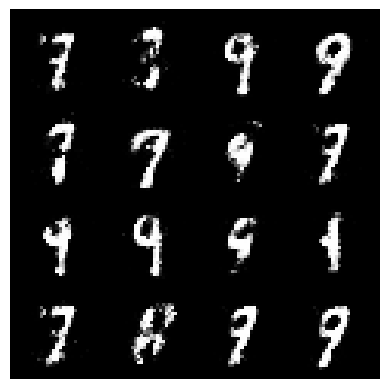

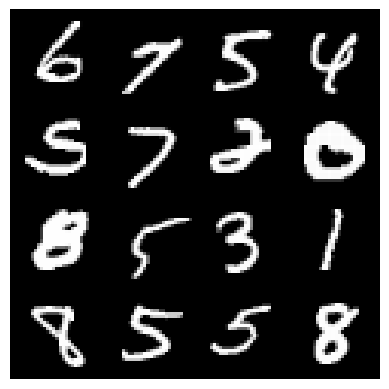

Epoch 78: Step 36900 / Gen loss: 3.3931137204170216 / Disc loss: 0.13257934680829453


  0%|          | 0/469 [00:00<?, ?it/s]

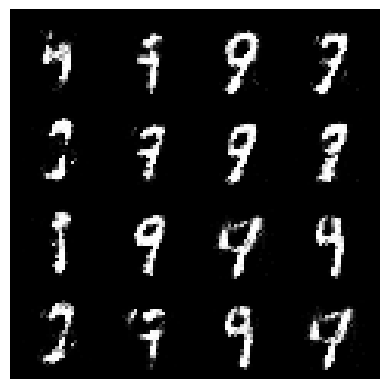

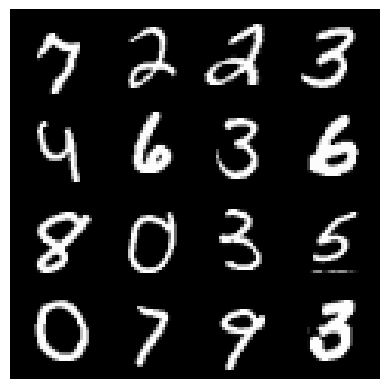

Epoch 79: Step 37200 / Gen loss: 3.485087337493899 / Disc loss: 0.12259793822964028


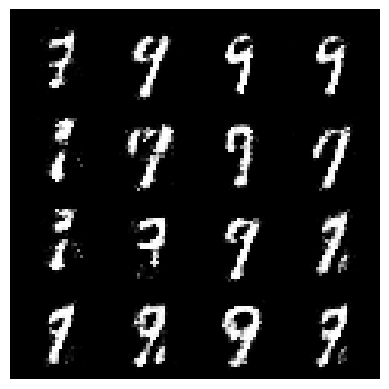

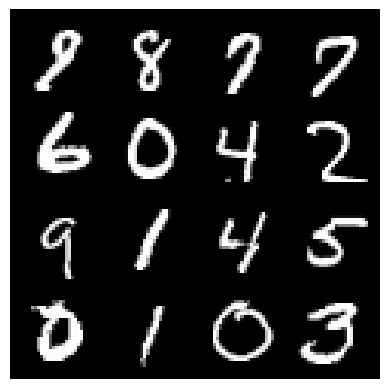

Epoch 79: Step 37500 / Gen loss: 3.603999029795327 / Disc loss: 0.12291714639713364


  0%|          | 0/469 [00:00<?, ?it/s]

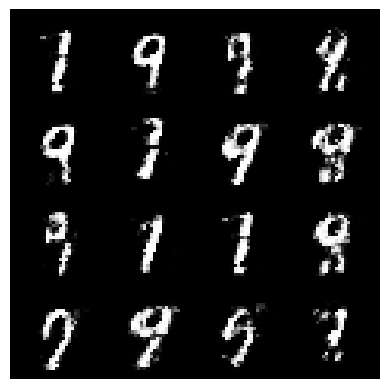

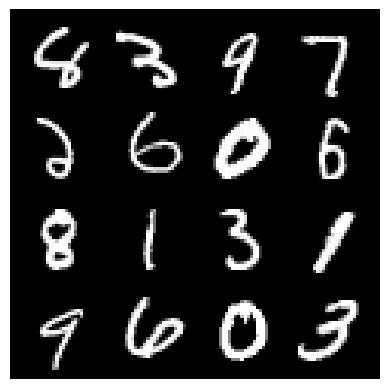

Epoch 80: Step 37800 / Gen loss: 3.4286695392926543 / Disc loss: 0.14973577695588267


  0%|          | 0/469 [00:00<?, ?it/s]

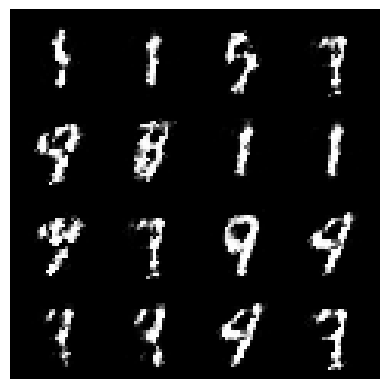

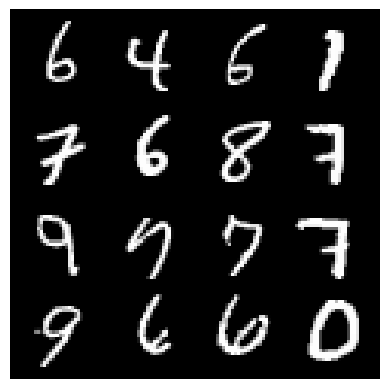

Epoch 81: Step 38100 / Gen loss: 3.300499674479165 / Disc loss: 0.14903235810498403


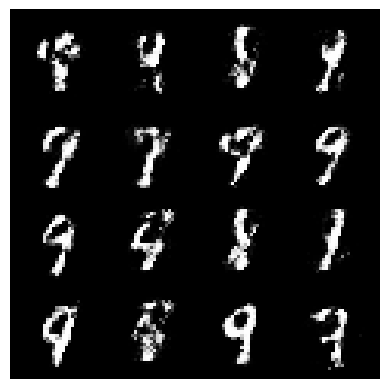

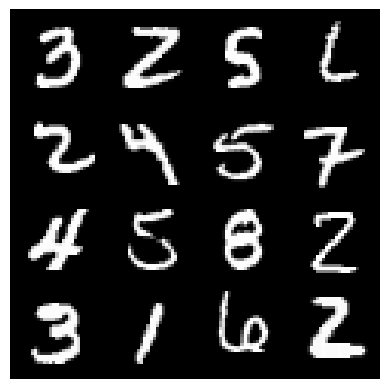

Epoch 81: Step 38400 / Gen loss: 3.346530782381695 / Disc loss: 0.15158177506178613


  0%|          | 0/469 [00:00<?, ?it/s]

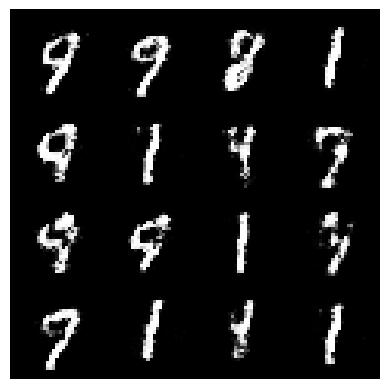

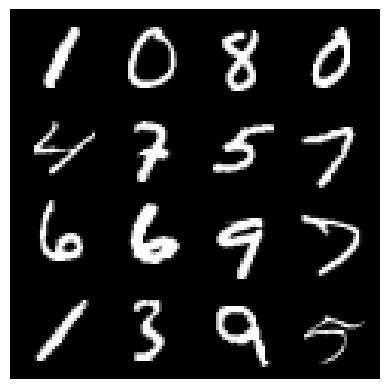

Epoch 82: Step 38700 / Gen loss: 3.398060083389279 / Disc loss: 0.1473288817703724


  0%|          | 0/469 [00:00<?, ?it/s]

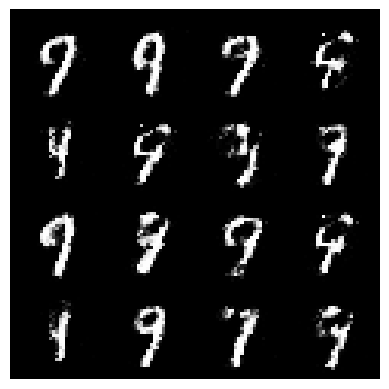

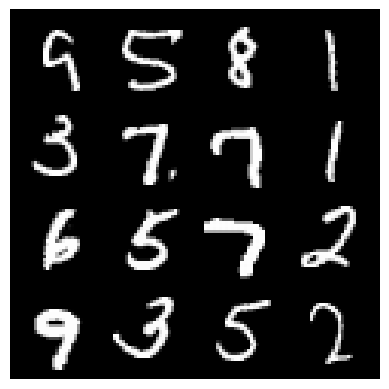

Epoch 83: Step 39000 / Gen loss: 3.2832826717694625 / Disc loss: 0.1630975554635127


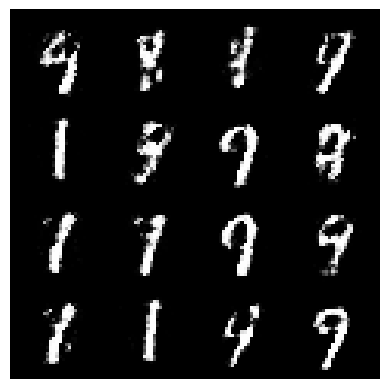

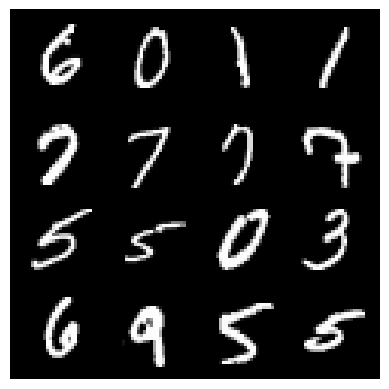

Epoch 83: Step 39300 / Gen loss: 3.1813860313097635 / Disc loss: 0.16702050367991125


  0%|          | 0/469 [00:00<?, ?it/s]

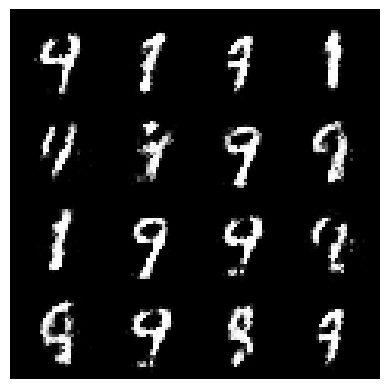

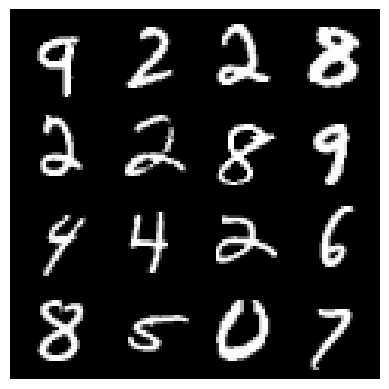

Epoch 84: Step 39600 / Gen loss: 3.151042135556538 / Disc loss: 0.16361108099420862


  0%|          | 0/469 [00:00<?, ?it/s]

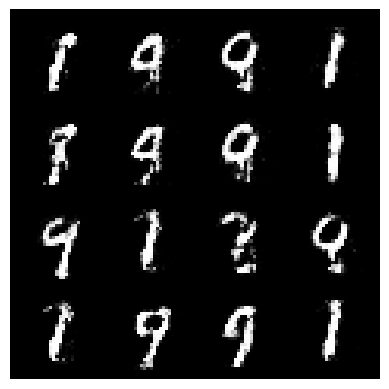

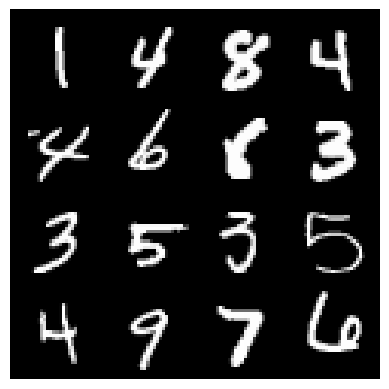

Epoch 85: Step 39900 / Gen loss: 3.1931281948089616 / Disc loss: 0.15552649388710668


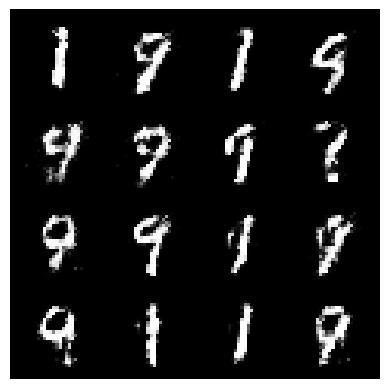

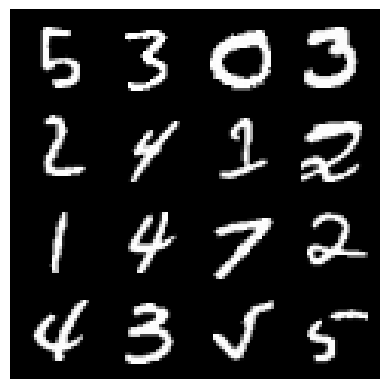

Epoch 85: Step 40200 / Gen loss: 3.0876977491378783 / Disc loss: 0.17765935319165402


  0%|          | 0/469 [00:00<?, ?it/s]

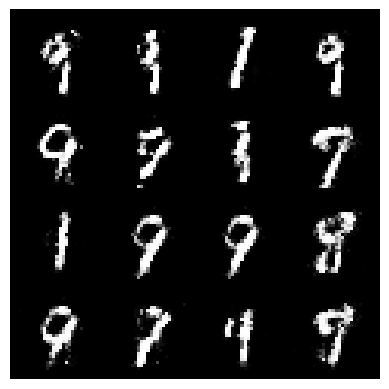

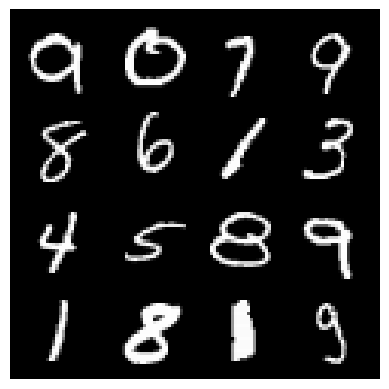

Epoch 86: Step 40500 / Gen loss: 3.1627483423550906 / Disc loss: 0.15779191531240946


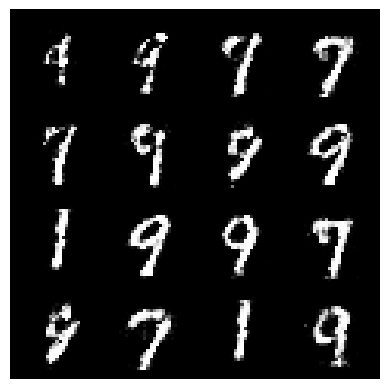

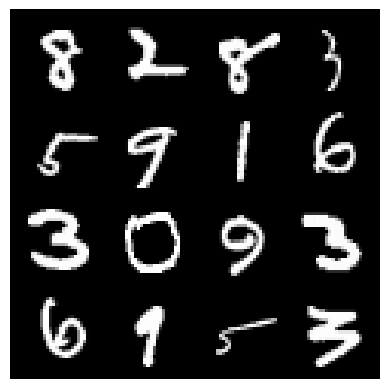

Epoch 86: Step 40800 / Gen loss: 3.0215034349759424 / Disc loss: 0.1812781067440906


  0%|          | 0/469 [00:00<?, ?it/s]

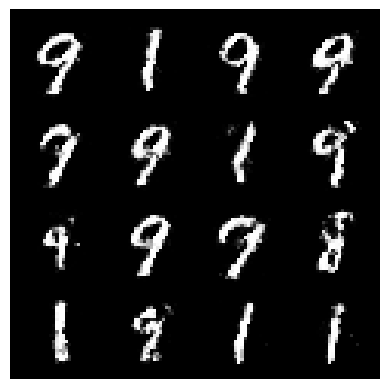

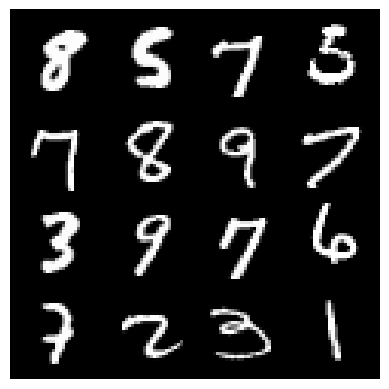

Epoch 87: Step 41100 / Gen loss: 2.9317868479092914 / Disc loss: 0.198639987980326


  0%|          | 0/469 [00:00<?, ?it/s]

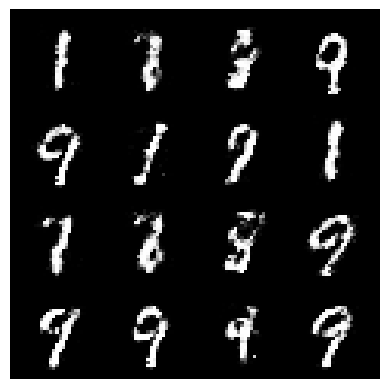

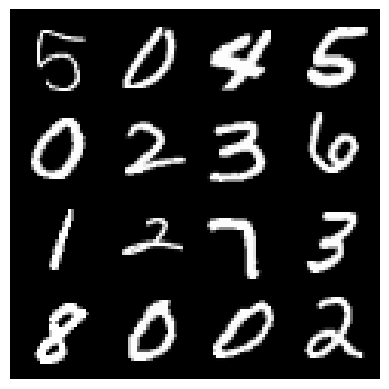

Epoch 88: Step 41400 / Gen loss: 2.9125089144706733 / Disc loss: 0.1827915283292532


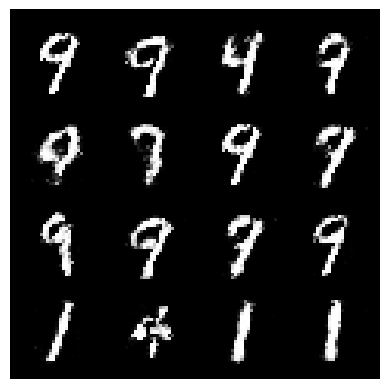

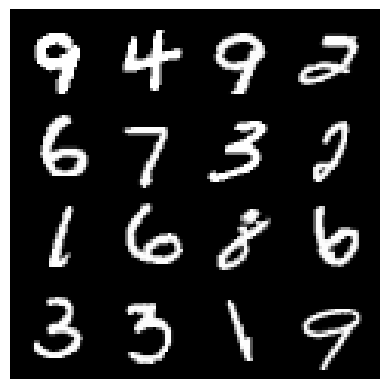

Epoch 88: Step 41700 / Gen loss: 2.9251870234807344 / Disc loss: 0.17853406839072708


  0%|          | 0/469 [00:00<?, ?it/s]

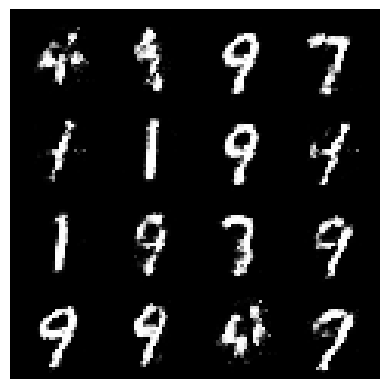

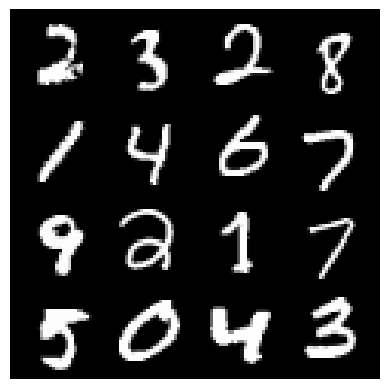

Epoch 89: Step 42000 / Gen loss: 2.9883682362238573 / Disc loss: 0.18847630523145192


  0%|          | 0/469 [00:00<?, ?it/s]

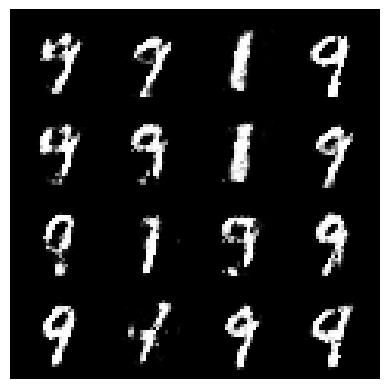

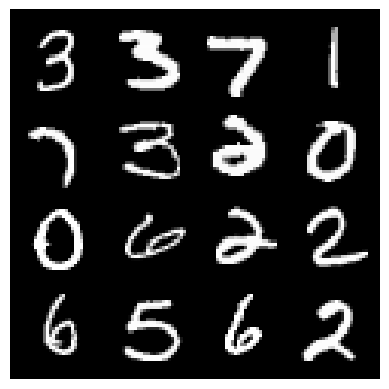

Epoch 90: Step 42300 / Gen loss: 2.82813532749812 / Disc loss: 0.21214011982083308


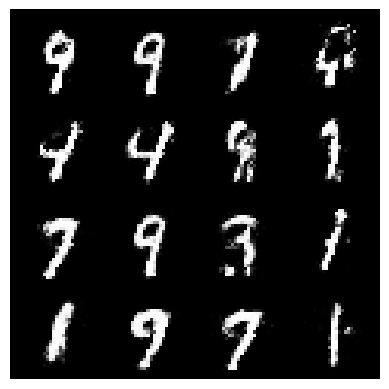

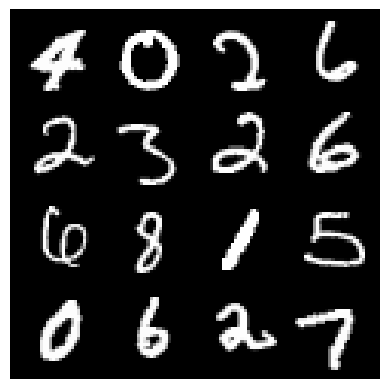

Epoch 90: Step 42600 / Gen loss: 2.864166761239369 / Disc loss: 0.18395712976654371


  0%|          | 0/469 [00:00<?, ?it/s]

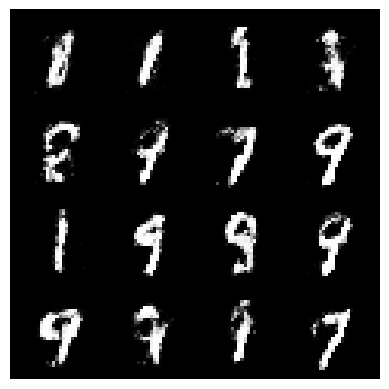

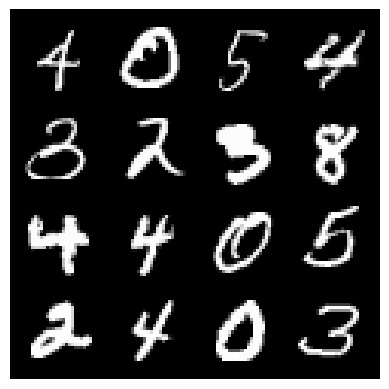

Epoch 91: Step 42900 / Gen loss: 2.828268485069275 / Disc loss: 0.200317572876811


  0%|          | 0/469 [00:00<?, ?it/s]

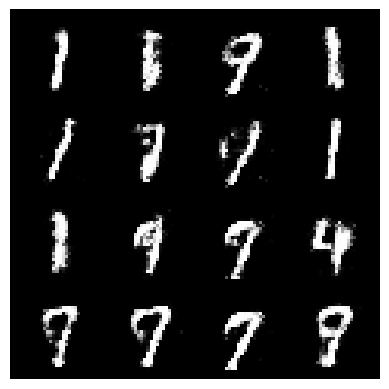

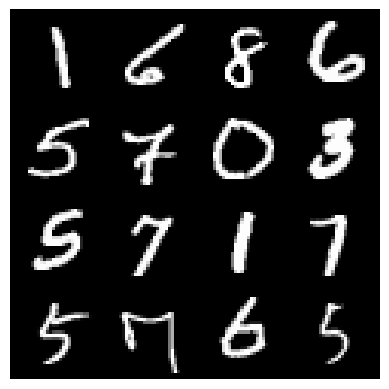

Epoch 92: Step 43200 / Gen loss: 2.636992417176565 / Disc loss: 0.22591332534948994


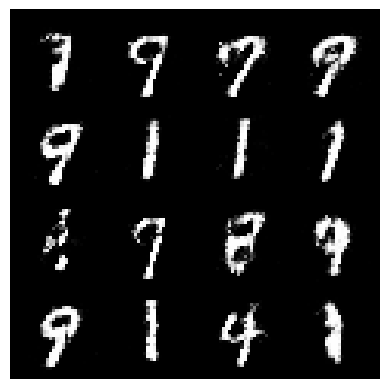

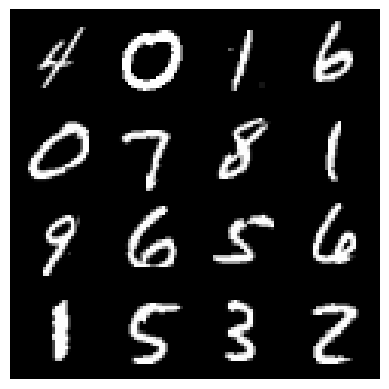

Epoch 92: Step 43500 / Gen loss: 2.6055962649981166 / Disc loss: 0.22001554672916715


  0%|          | 0/469 [00:00<?, ?it/s]

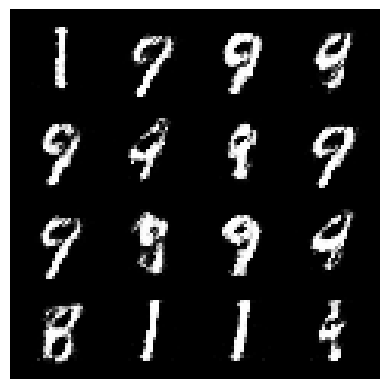

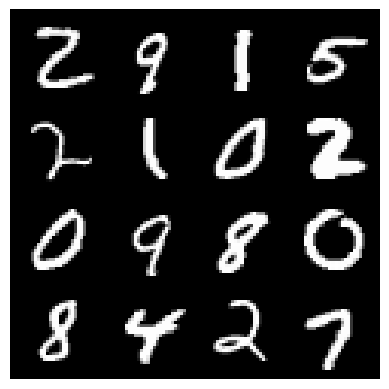

Epoch 93: Step 43800 / Gen loss: 2.6260796777407323 / Disc loss: 0.20840912324686858


  0%|          | 0/469 [00:00<?, ?it/s]

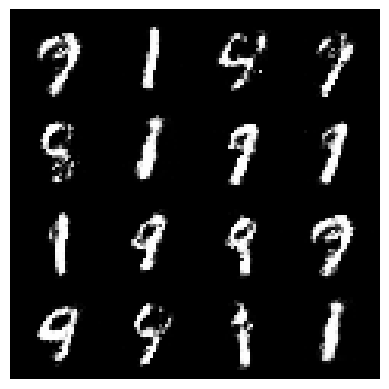

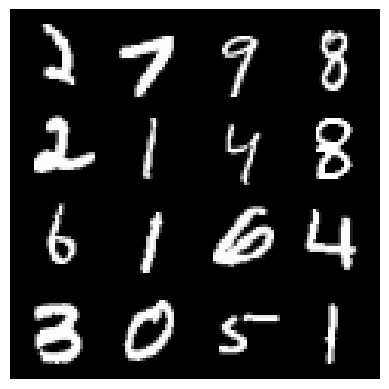

Epoch 94: Step 44100 / Gen loss: 2.6381959573427842 / Disc loss: 0.21879344666997588


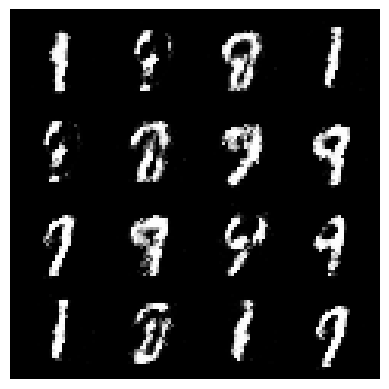

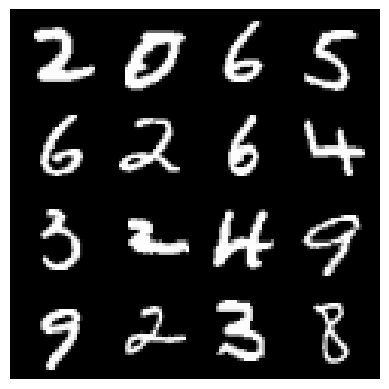

Epoch 94: Step 44400 / Gen loss: 2.6457649032274886 / Disc loss: 0.21053843619922794


  0%|          | 0/469 [00:00<?, ?it/s]

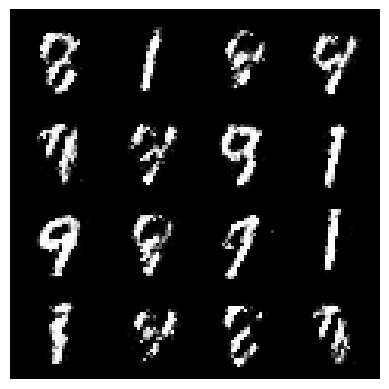

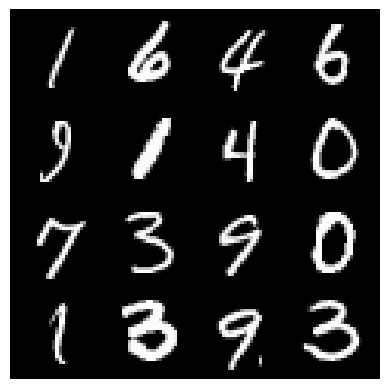

Epoch 95: Step 44700 / Gen loss: 2.752460333506264 / Disc loss: 0.19993827693164357


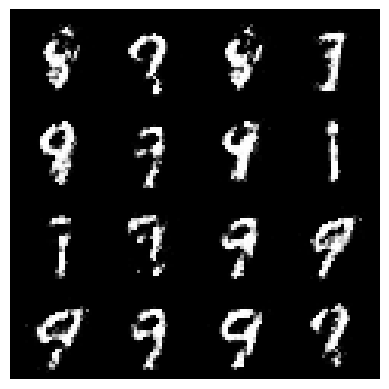

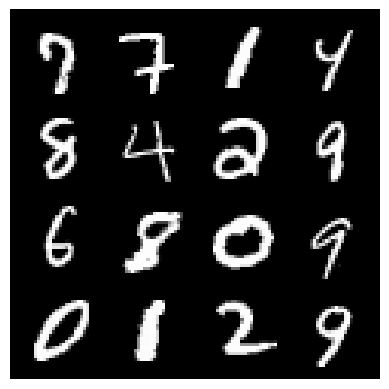

Epoch 95: Step 45000 / Gen loss: 2.726809229453406 / Disc loss: 0.21330278128385552


  0%|          | 0/469 [00:00<?, ?it/s]

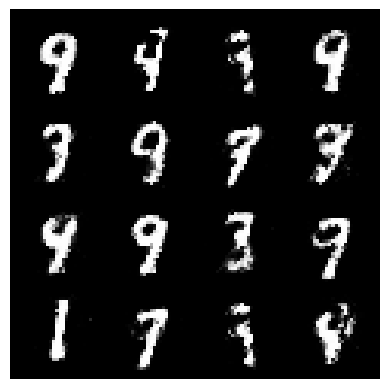

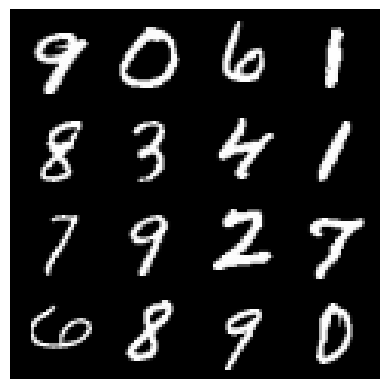

Epoch 96: Step 45300 / Gen loss: 2.6572829910119373 / Disc loss: 0.20953190955022954


  0%|          | 0/469 [00:00<?, ?it/s]

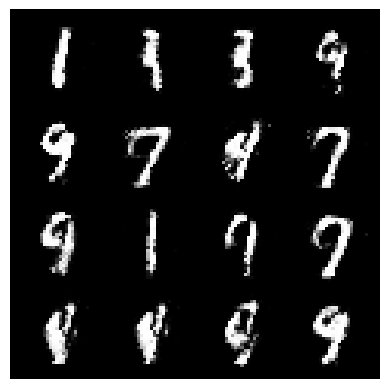

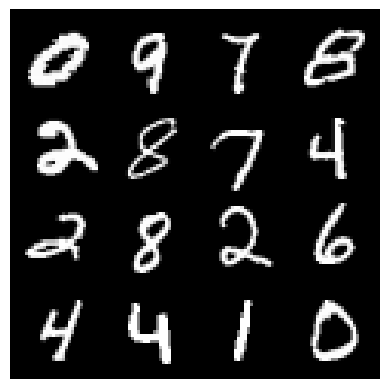

Epoch 97: Step 45600 / Gen loss: 2.546622479359307 / Disc loss: 0.2431568060318627


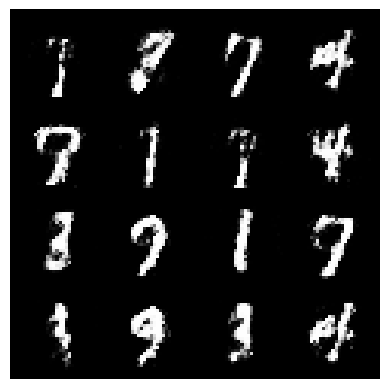

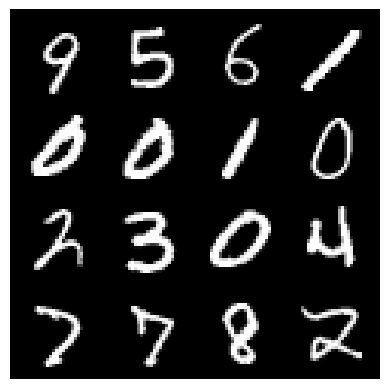

Epoch 97: Step 45900 / Gen loss: 2.44598421216011 / Disc loss: 0.24062345832586285


  0%|          | 0/469 [00:00<?, ?it/s]

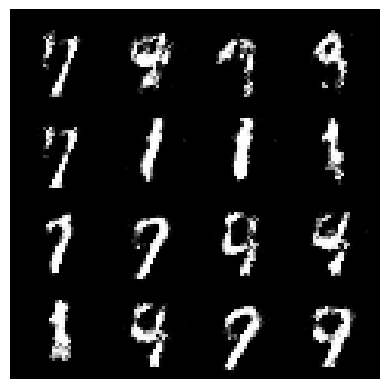

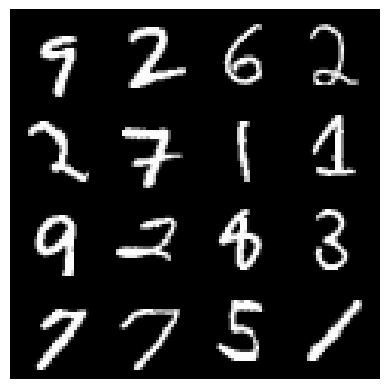

Epoch 98: Step 46200 / Gen loss: 2.5434529415766396 / Disc loss: 0.2148929563661416


  0%|          | 0/469 [00:00<?, ?it/s]

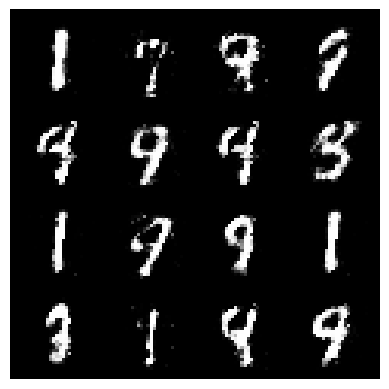

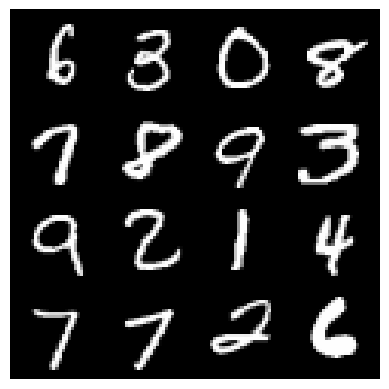

Epoch 99: Step 46500 / Gen loss: 2.611195083459217 / Disc loss: 0.21431167855858793


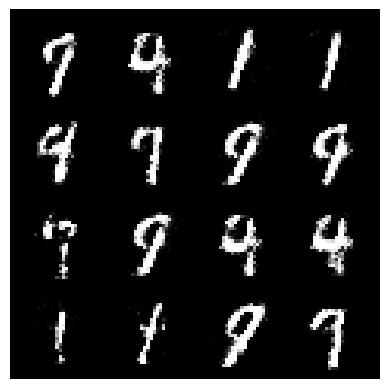

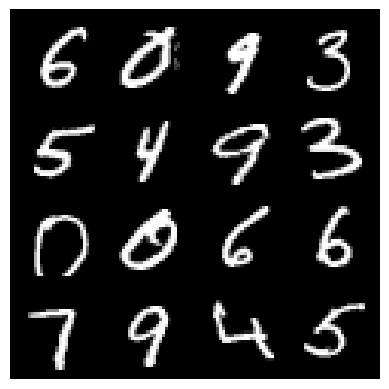

Epoch 99: Step 46800 / Gen loss: 2.5680712747573846 / Disc loss: 0.21403083359201766


In [ ]:
### There are approximately 469 steps in each epoch
### Each step processes 128 images, which is the size of the batch (except the last step of the epoch)

for epoch in range(epochs):
    for real, _ in tqdm(dataloader):
        ### Training the discriminator
        disc_opt.zero_grad()  # Clear the gradients of the discriminator

        cur_bs = len(real)  # Current batch size (number of images in the batch)
        real = real.view(cur_bs, -1)  # Flatten the real images to 2D tensors (batch_size x image_size)
        real = real.to(device)  # Move the real images to the GPU

        # Calculate the discriminator's loss
        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)
        disc_loss.backward(retain_graph=True)  # Backpropagate the loss to compute gradients
        disc_opt.step()  # Update the discriminator's parameters

        ### Training the generator
        gen_opt.zero_grad()  # Clear the gradients of the generator

        # Calculate the generator's loss
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        gen_loss.backward(retain_graph=True)  # Backpropagate the loss to compute gradients
        gen_opt.step()  # Update the generator's parameters

        ### Visualization & Statistics
        mean_disc_loss += disc_loss.item() / info_step  # Accumulate the discriminator loss
        mean_gen_loss += gen_loss.item() / info_step  # Accumulate the generator loss

        if cur_step % info_step == 0 and cur_step > 0:
            # Generate and visualize fake images from the current generator
            fake_noise = gen_noise(cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real)

            # Print the current epoch, step, and the average losses
            print(f"Epoch {epoch}: Step {cur_step} / Gen loss: {mean_gen_loss} / Disc loss: {mean_disc_loss}")

            # Reset the mean losses
            mean_gen_loss, mean_disc_loss = 0, 0

        cur_step += 1  # Increment the current step


In [ ]:
# Save the Generator
torch.save(gen.state_dict(), 'generator.pth')

# Save the Discriminator
torch.save(disc.state_dict(), 'discriminator.pth')


In [ ]:
# Instantiate the models
loaded_gen = Generator(z_dim).to(device)
loaded_disc = Discriminator().to(device)

# Load the state dictionaries
loaded_gen.load_state_dict(torch.load('/content/generator.pth'))
loaded_disc.load_state_dict(torch.load('/content/discriminator.pth'))


<All keys matched successfully>

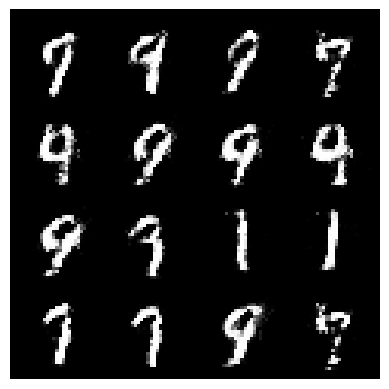

In [ ]:
# Function to generate images and display them
def generate_and_show_images(generator, num_images, z_dim):
    noise = gen_noise(num_images, z_dim)  # Generate random noise vectors
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # No need to track gradients
        fake_images = generator(noise)  # Generate fake images
    show(fake_images)  # Display the generated images

# Generate and display images
generate_and_show_images(loaded_gen, 16, z_dim)  # Change '16' to desired number of images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')